## Import Libraries

In [1]:
import os
import re
import pathlib
import json
import sqlalchemy as db

from datetime import datetime, date

import numpy as np
import pandas as pd
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
from statsmodels.graphics.gofplots import qqplot

import plotly.offline as pyo
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

pyo.init_notebook_mode(connected=True)


## Configurations

In [2]:
import quandl
import pandas_datareader as pdr
from pycoingecko import CoinGeckoAPI
import yfinance as yf

quandl.ApiConfig.api_key = "f6Y8avFQZwXp37ftC1_6"
cg = CoinGeckoAPI()


project_dir = pathlib.Path().absolute()
workdir = project_dir.parent
# print(f"{project_dir}\n{workdir}")

## Build functions

#### Local Functions for Data manipulation

In [3]:
def check_items(list1, list2):
    check = all(item in list1 for item in list2)
    return check

def value_mapper(df, col_name_to_map, new_col_name, mapping_dict):
    df[new_col_name] = df[col_name_to_map].str.upper().map(mapping_dict)
    return df

def df_subset(df, df_name, mapping_dict):
    columns_mapped = [i for i in mapping_dict[df_name][0]]
    df_subset = df[[column for column in df.columns if column in columns_mapped]]
    return df_subset


def column_rename(df, df_name, mapping_dict):
    df_renamed = df.rename(columns=mapping_dict[df_name][0])
    return df_renamed


def df_date_to_col(df):
    df_new_index = df.reset_index()
    df_date_col = df_new_index.rename(columns={'index': 'Date', 'date': 'Date'})
    return df_date_col


def sql_preprocess(df, df_name, mapping_dict):
    df_sub = df_subset(df, df_name, mapping_dict)
    df_ren = column_rename(df_sub, df_name, mapping_dict)
    df_prep = df_date_to_col(df_ren)
    return df_prep

def load_to_sql(table_name):
    engine = db.create_engine('sqlite:///crypto.db', echo=True)
    meta = db.MetaData(engine)

    with engine.connect() as con:
        df_btc_prep.to_sql(table_name, con=con, if_exists='replace', index=False)
        con.close()

def create_date_table(start='1900-01-01', end='2099-12-31'):
   df = pd.DataFrame({"Date": pd.date_range(start, end)})
   df["Week_day"] = df.Date.dt.day_name()
   df["Day"] = df.Date.dt.day
   df["Month"] = df.Date.dt.month
   df["Week"] = df.Date.dt.isocalendar().week
   df["Quarter"] = df.Date.dt.quarter
   df["Year"] = df.Date.dt.year
   df.insert(0, 'DateID', (df.Year.astype(str) + df.Month.astype(str).str.zfill(2) + df.Day.astype(str).str.zfill(2)).astype(int))
   return df

def calculate_average(row_col):
    return row_col.mean()


#### Data Import functions

In [4]:
def jprint(obj):
    text = json.dumps(obj, sort_keys=True, indent=4)
    print(text)

def get_json_data(data_id, json_path, provider):
    """Download and cache JSON data, return as a dataframe."""
    
    cache_path = f"{workdir}\\02_Resources\{data_id}.json"
    try:        
        f = open(cache_path, 'rb')
        df = pd.read_json(f)   
        print(f"Loaded {cache_path} from cache")
    except (OSError, IOError) as e:
        print(f"Downloading {data_id} from {provider}")
        df = pd.read_json(json_path)
        df.to_json(cache_path)
        print(f"Cached {data_id} at {cache_path}")
    return df



## Quandl Data import

def get_quandl_data(quandl_id):
    """" Download quandl data and load to json """
    
    data_id = quandl_id.replace('/', '-')
    provider = "Quandl"
    df = quandl.get(quandl_id, returns="pandas")
    json_path = df.to_json()
    return get_json_data(data_id, json_path, provider)


    
## Yahoo Finance Data import

def get_yfinance_data(ticker):
    """" Download yahoo finance data and load to json """
    
    data_id = re.sub(r'\W+', '_', ticker)
    provider = "Yahoo"
    df = yf.download(ticker)
    json_path = df.to_json()
    return get_json_data(data_id, json_path, provider)

## Data Reader Data import

def get_datareader_data(datareader_id, provider):
    """" Download datareader data and load to json """
    data_id = datareader_id
    df = pdr.DataReader(datareader_id, provider)
    if df.shape[0]!=df.index.nunique():
        idx = np.unique(df.index.values, return_index=True)[1]
        df = df.iloc[idx]    
            
    json_path = df.to_json()
    return get_json_data(data_id, json_path, provider)


## Poloniex Data import

base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.strptime('2014-01-01', '%Y-%m-%d') # get data from the start of 2014
end_date = datetime.now() # up until today
period = 86400 # pull daily data (86,400 seconds per day)

def get_poloniex_data(poloniex_pair):
    """Retrieve cryptocurrency data from poloniex"""
    
    data_id = poloniex_pair
    provider="Poloniex"
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), period)
    df = get_json_data(data_id, json_url, poloniex_pair)
    df = df.set_index('date')
    return df


## Initial Data Exploration

### Look at Quandl Data

In [5]:
df_sample_quandl_kraken = get_quandl_data('BCHARTS/KRAKENUSD')

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-KRAKENUSD.json from cache


In [6]:
df_sample_quandl_kraken.head()

Open       High        Low      Close  Volume (BTC)  \
2014-01-07  874.67040  892.06753  810.00000  810.00000     15.622378   
2014-01-08  810.00000  899.84281  788.00000  824.98287     19.182756   
2014-01-09  825.56345  870.00000  807.42084  841.86934      8.158335   
2014-01-10  839.99000  857.34056  817.00000  857.33056      8.024510   
2014-01-11  858.20000  918.05471  857.16554  899.84105     18.748285   

            Volume (Currency)  Weighted Price  
2014-01-07       13151.472844      841.835522  
2014-01-08       16097.329584      839.156269  
2014-01-09        6784.249982      831.572913  
2014-01-10        6780.220188      844.938794  
2014-01-11       16698.566929      890.671709

In [7]:
df_sample_quandl_kraken.index[0]

Timestamp('2014-01-07 00:00:00')

In [8]:
df_sample_quandl_kraken.index[-1]

Timestamp('2021-04-07 00:00:00')

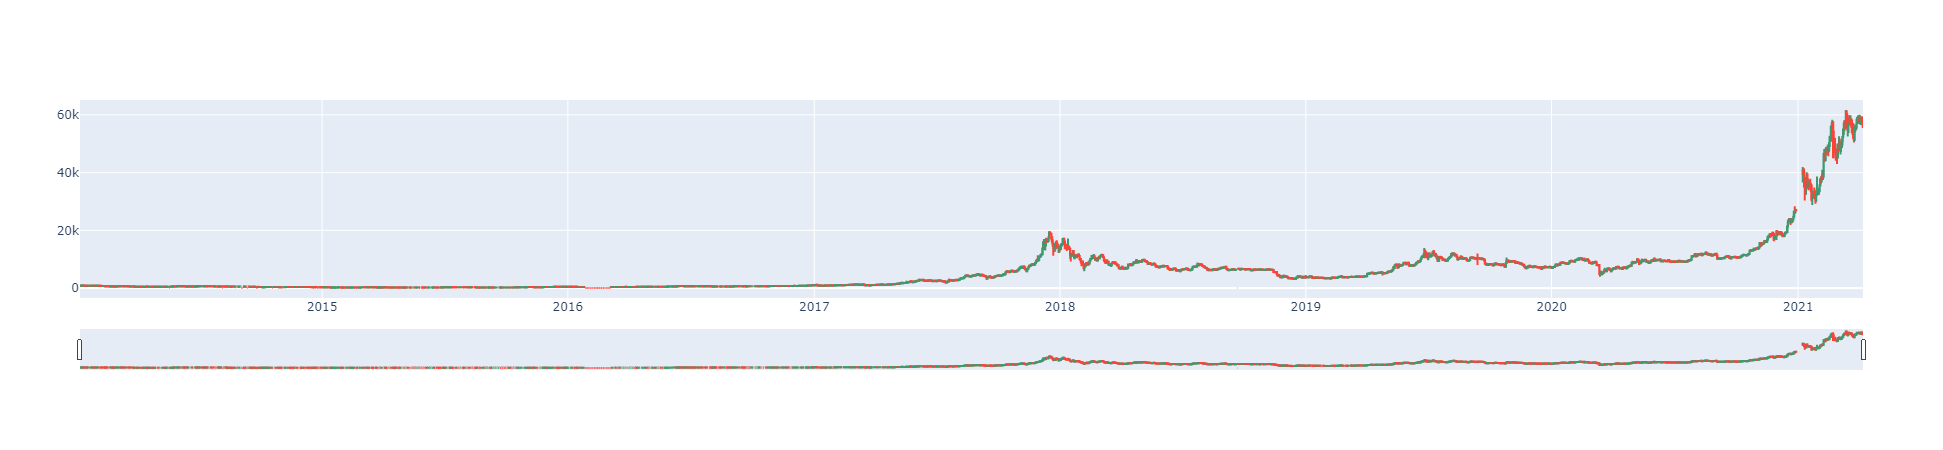

In [9]:
fig = go.Figure(data=[go.Candlestick(x=df_sample_quandl_kraken.index,
                open=df_sample_quandl_kraken['Open'],
                high=df_sample_quandl_kraken['High'],
                low=df_sample_quandl_kraken['Low'],
                close=df_sample_quandl_kraken['Close'])])
fig.show()

### Look at Coingecko market & exchange data

In [10]:
coins_list = cg.get_coins_list()
coin_names = []
for item in coins_list:
    coin_names.append(item['name'])

In [11]:
# jprint(coins_list)

In [12]:
markets_list = cg.get_coins_markets(vs_currency='usd')
market_names = []
for item in markets_list:
    market_names.append(item['name'])
len(market_names)

100

In [13]:
# jprint(markets_list)

In [14]:
df_cg_markets = pd.DataFrame.from_dict(markets_list)
df_cg_markets.head()

id symbol          name  \
0      bitcoin    btc       Bitcoin   
1     ethereum    eth      Ethereum   
2  binancecoin    bnb  Binance Coin   
3       ripple    xrp           XRP   
4       tether   usdt        Tether   

                                               image  current_price  \
0  https://assets.coingecko.com/coins/images/1/la...   58019.000000   
1  https://assets.coingecko.com/coins/images/279/...    2064.580000   
2  https://assets.coingecko.com/coins/images/825/...     442.660000   
3  https://assets.coingecko.com/coins/images/44/l...       1.030000   
4  https://assets.coingecko.com/coins/images/325/...       0.999503   

      market_cap  market_cap_rank  fully_diluted_valuation  total_volume  \
0  1083818432047                1             1.218539e+12   45513950034   
1   238252506191                2                      NaN   25141764921   
2    68309910582                3             7.538254e+10    5776554736   
3    47253097218                4                      NaN    8780967070   
4    43883964993                5                      NaN   94413452141   

   high_24h  ...  total_supply   max_supply       ath  ath_change_percentage  \
0  58848.00  ...  2.100000e+07   21000000.0  61712.00               -6.07839   
1   2110.40  ...           NaN          NaN   2153.08               -4.27161   
2    446.11  ...  1.705337e+08  170533651.9    446.11               -1.31045   
3      1.08  ...  1.000000e+11          NaN      3.40              -69.73184   
4      1.00  ...  4.390580e+10          NaN      1.32              -24.45724   

                   ath_date        atl  atl_change_percentage  \
0  2021-03-13T20:49:26.606Z  67.810000           8.537653e+04   
1  2021-04-06T01:14:31.985Z   0.432979           4.759312e+05   
2  2021-04-09T14:13:55.939Z   0.039818           1.105593e+06   
3  2018-01-07T00:00:00.000Z   0.002686           3.819371e+04   
4  2018-07-24T00:00:00.000Z   0.572521           7.457922e+01   

                   atl_date  \
0  2013-07-06T00:00:00.000Z   
1  2015-10-20T00:00:00.000Z   
2  2017-10-19T00:00:00.000Z   
3  2014-05-22T00:00:00.000Z   
4  2015-03-02T00:00:00.000Z   

                                                 roi              last_updated  
0                                               None  2021-04-09T23:36:47.316Z  
1  {'times': 46.572425198398, 'currency': 'btc', ...  2021-04-09T23:36:27.572Z  
2                                               None  2021-04-09T23:35:43.726Z  
3                                               None  2021-04-09T23:36:35.089Z  
4                                               None  2021-04-09T23:06:44.237Z  

[5 rows x 26 columns]

In [15]:
exchanges_list = cg.get_exchanges_list()
exchange_names = []
for item in exchanges_list:
    exchange_names.append(item['name'])
len(exchange_names)

100

In [16]:
jprint(exchanges_list[0]['name'])

"Binance"


In [17]:
df_cg_exchanges = pd.DataFrame.from_dict(exchanges_list)
df_cg_exchanges['name']

0          Binance
1     Coinbase Pro
2           Kraken
3         Bitfinex
4       Binance US
          ...     
95       Vebitcoin
96         Exrates
97      CoinMargin
98          KickEX
99       GMO Japan
Name: name, Length: 100, dtype: object

### Look at Coingecko BTC data

In [18]:
start_date = datetime.strptime("2014-01-07", "%Y-%m-%d")
end_date = datetime.strptime("2021-04-01", "%Y-%m-%d")
timestamp_start = datetime.timestamp(start_date)
timestamp_end = datetime.timestamp(end_date)

In [19]:
btc_charts_data = cg.get_coin_market_chart_range_by_id("bitcoin", "usd", timestamp_start, timestamp_end)

In [20]:
# jprint(btc_charts_data)

In [21]:
for key, value in enumerate(btc_charts_data):
    elements = []
    for element in btc_charts_data[value]:
        elements.append(element)
    print(f"{value}: # {len(elements)}")

prices: # 2640
market_caps: # 2639
total_volumes: # 2640


In [22]:
df_btc_charts_data_mc = pd.DataFrame.from_dict(btc_charts_data['market_caps'])
df_btc_charts_data_mc.rename(columns={0:'timestamp', 1:'market_cap'}, inplace=True)
df_btc_charts_data_mc['datetime'] = pd.to_datetime(df_btc_charts_data_mc['timestamp'], unit='ms')
df_btc_charts_data_mc.drop('timestamp', axis=1, inplace=True)
df_btc_charts_data_mc.set_index('datetime', inplace=True)
print(f"Duplicated indices: {df_btc_charts_data_mc.index.duplicated().sum()}")
df_btc_charts_data_mc.tail()

Duplicated indices: 0


market_cap
datetime                
2021-03-27  1.027210e+12
2021-03-28  1.042184e+12
2021-03-29  1.039334e+12
2021-03-30  1.075942e+12
2021-03-31  1.095293e+12

In [23]:
df_btc_charts_data_mc = pd.DataFrame.from_dict(btc_charts_data['market_caps'])
df_btc_charts_data_mc.rename(columns={0:'timestamp', 1:'market_cap'}, inplace=True)

df_btc_charts_data_pc = pd.DataFrame.from_dict(btc_charts_data['prices'])
df_btc_charts_data_pc.rename(columns={0:'timestamp', 1:'price'}, inplace=True)

df_btc_charts_data_vol = pd.DataFrame.from_dict(btc_charts_data['total_volumes'])
df_btc_charts_data_vol.rename(columns={0:'timestamp', 1:'volume'}, inplace=True)


In [24]:
df_btc_charts_merged = df_btc_charts_data_mc.merge(df_btc_charts_data_pc, how="inner", 
                                                   left_on='timestamp', right_on='timestamp').merge(df_btc_charts_data_vol,
                                                                                                                how='inner', left_on='timestamp', 
                                                                                                                 right_on='timestamp')
df_btc_charts_merged.tail()

timestamp    market_cap         price        volume
2634  1616803200000  1.027210e+12  55033.100480  5.544256e+10
2635  1616889600000  1.042184e+12  55832.418110  4.728575e+10
2636  1616976000000  1.039334e+12  55728.101328  4.931585e+10
2637  1617062400000  1.075942e+12  57634.928694  5.738704e+10
2638  1617148800000  1.095293e+12  58668.628337  5.238754e+10

In [25]:
df_btc_charts_merged['datetime'] = pd.to_datetime(df_btc_charts_merged['timestamp'], unit='ms')
df_cg_btc_data = df_btc_charts_merged.set_index('datetime')
df_cg_btc_data.drop('timestamp', axis=1, inplace=True)
df_cg_btc_data.tail()

market_cap         price        volume
datetime                                            
2021-03-27  1.027210e+12  55033.100480  5.544256e+10
2021-03-28  1.042184e+12  55832.418110  4.728575e+10
2021-03-29  1.039334e+12  55728.101328  4.931585e+10
2021-03-30  1.075942e+12  57634.928694  5.738704e+10
2021-03-31  1.095293e+12  58668.628337  5.238754e+10

In [26]:
print(f"Duplicated indices: {df_cg_btc_data.index.duplicated().sum()}")
print(df_cg_btc_data.nunique())

Duplicated indices: 0
market_cap    2639
price         2638
volume        2639
dtype: int64


In [27]:
df_cg_btc_data[df_cg_btc_data.index.duplicated()]

Empty DataFrame
Columns: [market_cap, price, volume]
Index: []

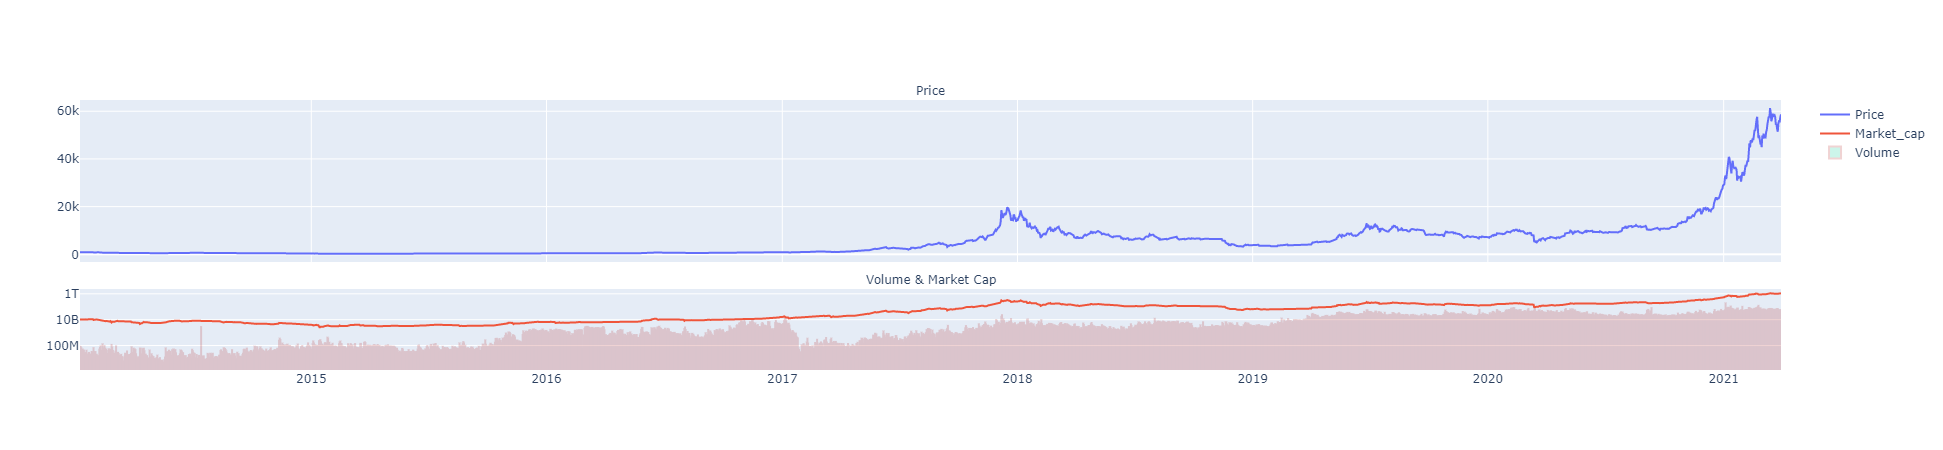

In [28]:
fig = go.Figure()

date = df_cg_btc_data.index
price = df_cg_btc_data['price']
market_cap = df_cg_btc_data['market_cap']
volume = df_cg_btc_data['volume']

fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                   vertical_spacing=0.1, subplot_titles=('Price', 'Volume & Market Cap'),
                   row_width=[0.5, 1])

fig.add_trace(go.Scatter(x=date, y=price,
                    mode='lines',
                    name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=date, y=market_cap,
                    name='Market_cap'), row=2, col=1)

fig.add_trace(go.Bar(x=date, y=volume,
                     name='Volume',
                     opacity=0.2,
                     marker=dict(
                         line=dict(color='firebrick', width=2)
                     )), row=2, col=1)

fig.update_annotations(font_size=12)



fig.update_layout(yaxis2_type="log")

fig.show()

### Look at Yahoo Finance BTC data

In [29]:
df_yahoo_btc_data = get_datareader_data('BTC-USD', "yahoo")
df_yahoo_btc_data.tail()

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC-USD.json from cache


High           Low          Open         Close  \
2021-04-02  60110.269531  57603.890625  59397.410156  57603.890625   
2021-04-03  58913.746094  57168.675781  57604.839844  58758.554688   
2021-04-04  59891.296875  57694.824219  58760.875000  59057.878906   
2021-04-05  59479.578125  57646.808594  59171.933594  58192.359375   
2021-04-07  58731.144531  55664.093750  56048.933594  56605.425781   

                 Volume     Adj Close  
2021-04-02  59641344484  57603.890625  
2021-04-03  50749662970  58758.554688  
2021-04-04  60706272115  59057.878906  
2021-04-05  66058027988  58192.359375  
2021-04-07  75652292608  56605.425781

### Comparison Chart BTC Closing Price

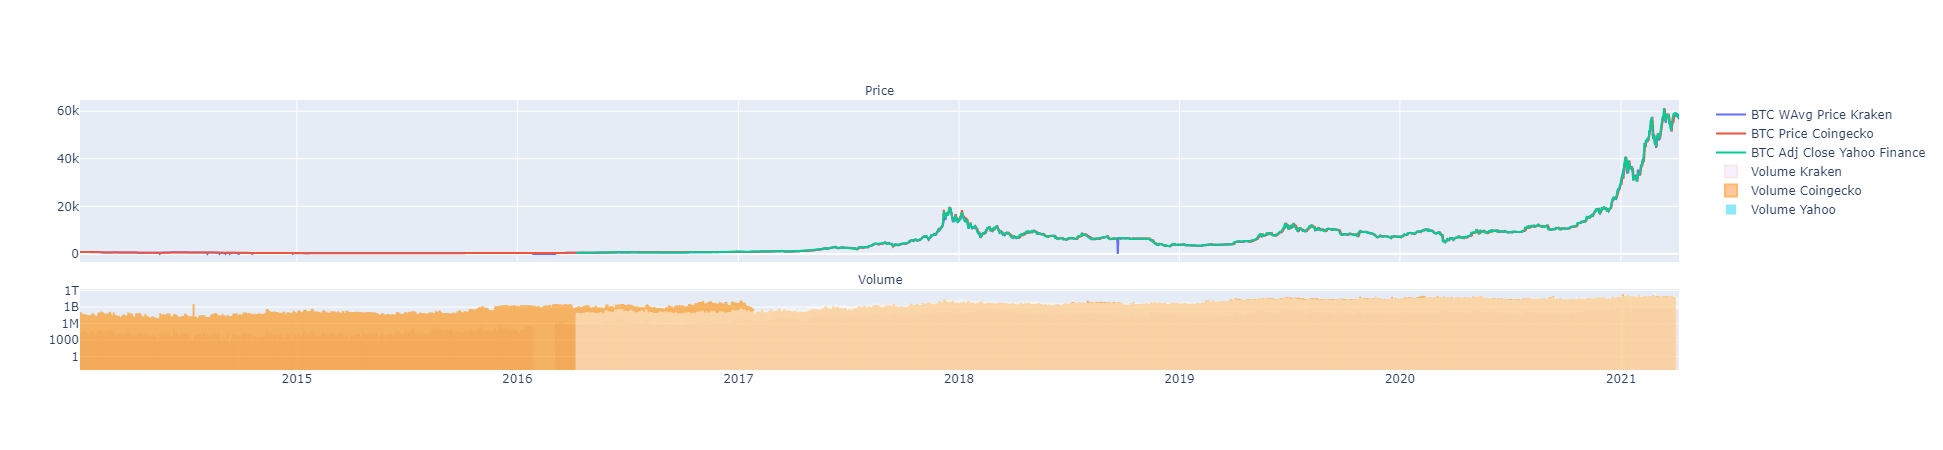

In [30]:
fig = go.Figure()

quandl_kraken = df_sample_quandl_kraken
coingecko = df_cg_btc_data
yahoo = df_yahoo_btc_data

fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                   vertical_spacing=0.1, subplot_titles=('Price', 'Volume'),
                   row_width=[0.5, 1])

fig.add_trace(go.Scatter(x=quandl_kraken.index, y=quandl_kraken['Weighted Price'],
                         mode='lines',
                         name='BTC WAvg Price Kraken'), row=1, col=1)

fig.add_trace(go.Scatter(x=coingecko.index, y=coingecko['price'],
                         mode='lines',
                         name='BTC Price Coingecko'), row=1, col=1)

fig.add_trace(go.Scatter(x=yahoo.index, y=yahoo['Adj Close'],
                         mode='lines',
                         name='BTC Adj Close Yahoo Finance'), row=1, col=1)


fig.add_trace(go.Bar(x=quandl_kraken.index, y=quandl_kraken['Volume (Currency)'],
                     name='Volume Kraken',
                     opacity=0.1,
                     marker=dict(
                         line=dict(color='firebrick', width=2)
                     )), row=2, col=1)

fig.add_trace(go.Bar(x=coingecko.index, y=coingecko['volume'],
                     name='Volume Coingecko',
                     opacity=0.6,
                     marker=dict(
                         line=dict(color='darkorange', width=2)
                     )), row=2, col=1)

fig.add_trace(go.Bar(x=yahoo.index, y=yahoo['Volume'],
                     name='Volume Yahoo',
                     opacity=0.5,
                     marker=dict(
                         line=dict(color='floralwhite', width=2)
                     )), row=2, col=1)

fig.update_annotations(font_size=12)

fig.update_layout(yaxis2_type="log")

fig.show()

## Data Ingestion: Populate BTC Data

### Inject more Exchange data from Quandl

In [31]:
from quandl.errors.quandl_error import NotFoundError

exchanges = df_cg_exchanges['id'].str.upper()

df_run_all = []
    
for exchange in exchanges:
    exchange_code = f"BCHARTS/{exchange}USD"
   
    try:
        df = get_quandl_data(exchange_code)
        df['Exchange'] = exchange
        df_run_all.append(df)
        
    except NotFoundError as e:
        continue

df_quandl_btc_data = pd.concat(df_run_all)

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-KRAKENUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-BITFINEXUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-BITSTAMPUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-BITFLYERUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-CEXUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-P2PB2BUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-OKCOINUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-ITBITUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-HITBTCUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-EXMOUSD.json from cache


In [32]:
df_quandl_btc_data.rename(columns={'Volume (BTC)': 'Volume_BTC', 'Volume (Currency)': 'Volume_USD'}, inplace=True)
df_quandl_btc_data.tail()

Open     High      Low       Close  Volume_BTC  \
2016-12-10  767.41000  781.480  767.001  781.392000   93.921368   
2016-12-11  777.22601  781.392  768.200  774.010000  174.092208   
2016-12-12  777.00000  781.392  773.010  777.360000  123.089500   
2016-12-13  777.87000  785.000  776.070  777.000000  157.104986   
2016-12-14  779.84000  788.420  776.510  782.324888  145.169843   

               Volume_USD  Weighted Price Exchange  
2016-12-10   72570.451178      772.672424     EXMO  
2016-12-11  134912.559498      774.948868     EXMO  
2016-12-12   95670.032894      777.239596     EXMO  
2016-12-13  122457.873285      779.465225     EXMO  
2016-12-14  113392.991874      781.105703     EXMO

In [33]:
df_quandl_btc_data.sort_index()

Open      High       Low     Close   Volume_BTC    Volume_USD  \
2011-09-13      5.80      6.00      5.65      5.97    58.371382  3.460974e+02   
2011-09-14      5.58      5.72      5.52      5.53    61.145984  3.418548e+02   
2011-09-15      5.12      5.24      5.00      5.13    80.140795  4.082590e+02   
2011-09-16      4.82      4.87      4.80      4.85    39.914007  1.937631e+02   
2011-09-17      4.87      4.87      4.87      4.87     0.300000  1.461000e+00   
...              ...       ...       ...       ...          ...           ...   
2021-04-06  59135.36  59473.90  57216.00  58018.30  2711.397847  1.580943e+08   
2021-04-06  59120.00  59462.80  57377.10  58017.10  2656.521275  1.550577e+08   
2021-04-07  57966.30  58531.30  55426.90  56433.00   216.640963  1.228639e+07   
2021-04-07  58024.90  58668.00  55441.93  56420.44  5330.356138  3.021940e+08   
2021-04-07  58017.20  58652.10  55460.00  56407.10  4890.372655  2.776886e+08   

            Weighted Price  Exchange  
2011-09-13        5.929231  BITSTAMP  
2011-09-14        5.590798  BITSTAMP  
2011-09-15        5.094272  BITSTAMP  
2011-09-16        4.854515  BITSTAMP  
2011-09-17        4.870000  BITSTAMP  
...                    ...       ...  
2021-04-06    58307.308273  BITSTAMP  
2021-04-06    58368.715387    KRAKEN  
2021-04-07    56713.133532       CEX  
2021-04-07    56693.026676  BITSTAMP  
2021-04-07    56782.705907    KRAKEN  

[14146 rows x 8 columns]

### Inject BTC Data from Poloniex

In [34]:
df_poloniex_btc_data = get_poloniex_data("USDT_BTC")
df_poloniex_btc_data.columns= df_poloniex_btc_data.columns.str.title()
df_poloniex_btc_data = df_poloniex_btc_data.rename(columns={'Volume': 'Volume_USD', 'Quotevolume': 'Volume_BTC',  
                                                     'Weightedaverage': 'Weighted Price'})

df_poloniex_btc_data['Exchange'] = 'POLONIEX'
column_names_btc=['Open', 'High', 'Low', 'Close', 'Volume_BTC', 'Volume_USD', 'Weighted Price', 'Exchange']
df_poloniex_btc_data = df_poloniex_btc_data.reindex(columns=column_names_btc)

df_poloniex_btc_data.tail()

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\USDT_BTC.json from cache


Open          High           Low         Close  \
date                                                                 
2021-03-27  55008.350978  56645.325460  53967.742633  55855.274815   
2021-03-28  55828.000000  56517.750699  54700.000000  55773.962120   
2021-03-29  55769.134151  58332.142365  54940.245881  57620.809447   
2021-03-30  57614.000000  59360.000000  57085.000000  58748.000000   
2021-03-31  58748.000000  59782.490733  56846.531521  58743.337525   

             Volume_BTC    Volume_USD  Weighted Price  Exchange  
date                                                             
2021-03-27   521.355309  2.880248e+07    55245.398905  POLONIEX  
2021-03-28   426.410099  2.379101e+07    55793.739993  POLONIEX  
2021-03-29   786.820766  4.498012e+07    57166.920136  POLONIEX  
2021-03-30   508.525830  2.964910e+07    58304.022460  POLONIEX  
2021-03-31  1025.147455  6.003219e+07    58559.565409  POLONIEX

In [35]:
df_poloniex_btc_data.sort_index()

Open          High           Low         Close  \
date                                                                 
2015-02-19    225.000000    244.000000    225.000000    244.000000   
2015-02-20    240.250118    245.000000    240.250000    240.250000   
2015-02-21    245.000000    245.000000    245.000000    245.000000   
2015-02-22    245.000000    249.000000    235.000000    235.000000   
2015-02-23    235.000002    235.001000    235.000000    235.000000   
...                  ...           ...           ...           ...   
2021-03-27  55008.350978  56645.325460  53967.742633  55855.274815   
2021-03-28  55828.000000  56517.750699  54700.000000  55773.962120   
2021-03-29  55769.134151  58332.142365  54940.245881  57620.809447   
2021-03-30  57614.000000  59360.000000  57085.000000  58748.000000   
2021-03-31  58748.000000  59782.490733  56846.531521  58743.337525   

             Volume_BTC    Volume_USD  Weighted Price  Exchange  
date                                                             
2015-02-19     0.193117  4.627631e+01      239.627778  POLONIEX  
2015-02-20     0.230429  5.589490e+01      242.568479  POLONIEX  
2015-02-21     0.060091  1.472224e+01      245.000000  POLONIEX  
2015-02-22     0.539055  1.291212e+02      239.532608  POLONIEX  
2015-02-23     0.410926  9.656756e+01      235.000062  POLONIEX  
...                 ...           ...             ...       ...  
2021-03-27   521.355309  2.880248e+07    55245.398905  POLONIEX  
2021-03-28   426.410099  2.379101e+07    55793.739993  POLONIEX  
2021-03-29   786.820766  4.498012e+07    57166.920136  POLONIEX  
2021-03-30   508.525830  2.964910e+07    58304.022460  POLONIEX  
2021-03-31  1025.147455  6.003219e+07    58559.565409  POLONIEX  

[2233 rows x 8 columns]

### Append Poloniex Data to have the final BTC Dataset

In [36]:
df_btc_data = df_quandl_btc_data.append(df_poloniex_btc_data)
df_btc_data.sort_values(by=['Exchange'])
df_btc_data.tail()

Open          High           Low         Close  \
2021-03-27  55008.350978  56645.325460  53967.742633  55855.274815   
2021-03-28  55828.000000  56517.750699  54700.000000  55773.962120   
2021-03-29  55769.134151  58332.142365  54940.245881  57620.809447   
2021-03-30  57614.000000  59360.000000  57085.000000  58748.000000   
2021-03-31  58748.000000  59782.490733  56846.531521  58743.337525   

             Volume_BTC    Volume_USD  Weighted Price  Exchange  
2021-03-27   521.355309  2.880248e+07    55245.398905  POLONIEX  
2021-03-28   426.410099  2.379101e+07    55793.739993  POLONIEX  
2021-03-29   786.820766  4.498012e+07    57166.920136  POLONIEX  
2021-03-30   508.525830  2.964910e+07    58304.022460  POLONIEX  
2021-03-31  1025.147455  6.003219e+07    58559.565409  POLONIEX

In [37]:
df_btc_data['Market'] = "BTC"
df_btc_data.sort_index()

Open      High       Low     Close   Volume_BTC    Volume_USD  \
2011-09-13      5.80      6.00      5.65      5.97    58.371382  3.460974e+02   
2011-09-14      5.58      5.72      5.52      5.53    61.145984  3.418548e+02   
2011-09-15      5.12      5.24      5.00      5.13    80.140795  4.082590e+02   
2011-09-16      4.82      4.87      4.80      4.85    39.914007  1.937631e+02   
2011-09-17      4.87      4.87      4.87      4.87     0.300000  1.461000e+00   
...              ...       ...       ...       ...          ...           ...   
2021-04-06  59068.10  59386.30  57416.00  57977.80   115.941019  6.763586e+06   
2021-04-06  59135.36  59473.90  57216.00  58018.30  2711.397847  1.580943e+08   
2021-04-07  58024.90  58668.00  55441.93  56420.44  5330.356138  3.021940e+08   
2021-04-07  58017.20  58652.10  55460.00  56407.10  4890.372655  2.776886e+08   
2021-04-07  57966.30  58531.30  55426.90  56433.00   216.640963  1.228639e+07   

            Weighted Price  Exchange Market  
2011-09-13        5.929231  BITSTAMP    BTC  
2011-09-14        5.590798  BITSTAMP    BTC  
2011-09-15        5.094272  BITSTAMP    BTC  
2011-09-16        4.854515  BITSTAMP    BTC  
2011-09-17        4.870000  BITSTAMP    BTC  
...                    ...       ...    ...  
2021-04-06    58336.439525       CEX    BTC  
2021-04-06    58307.308273  BITSTAMP    BTC  
2021-04-07    56693.026676  BITSTAMP    BTC  
2021-04-07    56782.705907    KRAKEN    BTC  
2021-04-07    56713.133532       CEX    BTC  

[16379 rows x 9 columns]

## Data Ingestion: Populate Altcoin Data

In [38]:
df_cg_markets['symbol']

0      btc
1      eth
2      bnb
3      xrp
4     usdt
      ... 
95    ankr
96    chsb
97     rsr
98     amp
99     lsk
Name: symbol, Length: 100, dtype: object

In [39]:
from quandl.errors.quandl_error import NotFoundError

markets = df_cg_markets['symbol'].str.upper()

df_run_mkt_new = []
    
for market in markets:
    market_code = f"BITFINEX/{market}BTC"
   
    try:
        df = get_quandl_data(market_code)
        df['Market'] = market
        df_run_mkt_new.append(df)
        
    except NotFoundError as e:
        continue

df_altcoin_quandl = pd.concat(df_run_mkt_new)

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-ETHBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-XRPBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-DOTBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-ADABTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-LTCBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-BCHBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-XLMBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-TRXBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-VETBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-BTTBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITFINEX-EOSBTC.json

In [40]:
df_altcoin_quandl_data = df_altcoin_quandl.sort_index()

In [41]:
df_altcoin_quandl_data

High       Low       Mid      Last       Bid       Ask  \
2014-04-15  0.025870  0.024502  0.025606  0.025669  0.025366  0.025845   
2014-04-16  0.026310  0.025050  0.025303  0.025111  0.025110  0.025497   
2014-04-17  0.026025  0.025111  0.025445  0.025550  0.025341  0.025550   
2014-04-18  0.026439  0.025001  0.025251  0.025486  0.025094  0.025408   
2014-04-19  0.025789  0.025000  0.025616  0.025460  0.025451  0.025782   
...              ...       ...       ...       ...       ...       ...   
2021-04-07  0.000022  0.000021  0.000021  0.000021  0.000021  0.000021   
2021-04-07  0.000753  0.000674  0.000713  0.000717  0.000712  0.000713   
2021-04-07  0.000019  0.000015  0.000017  0.000017  0.000017  0.000017   
2021-04-07  0.001753  0.001176  0.001407  0.001413  0.001400  0.001413   
2021-04-07  0.000018  0.000017  0.000017  0.000017  0.000017  0.000017   

                  Volume Market  
2014-04-15  1.430187e+03    LTC  
2014-04-16  1.774144e+03    LTC  
2014-04-17  9.852923e+02    LTC  
2014-04-18  1.372240e+03    LTC  
2014-04-19  2.330634e+03    LTC  
...                  ...    ...  
2021-04-07  5.750732e+05    ADA  
2021-04-07  2.193003e+04    DOT  
2021-04-07  3.312960e+07    XRP  
2021-04-07  2.348164e+04    BTG  
2021-04-07  7.083155e+04    AMP  

[28751 rows x 8 columns]

In [42]:
altcoins = markets
df_run_altcoin_new = []

for altcoin in altcoins:
    coinpair = f"BTC_{altcoin}"
    try:
        df = get_poloniex_data(coinpair)
        df['Market'] = altcoin
        df_run_altcoin_new.append(df)
                
    except ValueError as e:
        continue

df_altcoin_poloniex = pd.concat(df_run_altcoin_new)

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_ETH.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_XRP.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_DOT.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_LTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_LINK.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_BCH.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_WBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_TRX.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_DOGE.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_EOS.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_XTZ.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_ATOM.json

In [43]:
df_altcoin_poloniex_data = df_altcoin_poloniex.sort_index()

In [44]:
df_altcoin_poloniex_data

high           low          open         close     volume  \
date                                                                            
2014-01-18  2.900000e-02  2.800000e-02  2.800000e-02  2.850000e-02   0.023696   
2014-01-19  2.830000e-02  2.830000e-02  2.830000e-02  2.830000e-02   0.000311   
2014-01-20  2.830000e-02  2.830000e-02  2.830000e-02  2.830000e-02   0.000000   
2014-01-21  2.300000e-06  2.200000e-06  2.200000e-06  2.300000e-06   0.013465   
2014-01-21  2.830000e-02  2.830000e-02  2.830000e-02  2.830000e-02   0.000000   
...                  ...           ...           ...           ...        ...   
2021-03-31  1.261500e-04  1.242100e-04  1.255000e-04  1.261500e-04   0.014222   
2021-03-31  4.500000e-07  4.000000e-07  4.300000e-07  4.400000e-07   7.483935   
2021-03-31  4.508000e-03  4.133010e-03  4.161090e-03  4.191210e-03  29.322857   
2021-03-31  3.076980e-03  3.023070e-03  3.065820e-03  3.041090e-03   0.792017   
2021-03-31  1.060200e-04  9.683000e-05  1.011000e-04  1.060200e-04   1.016691   

             quoteVolume  weightedAverage Market  
date                                              
2014-01-18  8.450990e-01     2.803904e-02    LTC  
2014-01-19  1.100000e-02     2.830000e-02    LTC  
2014-01-20  0.000000e+00     2.830000e-02    LTC  
2014-01-21  6.000000e+03     2.240000e-06   DOGE  
2014-01-21  0.000000e+00     2.830000e-02    LTC  
...                  ...              ...    ...  
2021-03-31  1.130724e+02     1.257700e-04    BNT  
2021-03-31  1.753603e+07     4.200000e-07     SC  
2021-03-31  6.776518e+03     4.327120e-03    XMR  
2021-03-31  2.603453e+02     3.042170e-03    DCR  
2021-03-31  1.006703e+04     1.009900e-04    LSK  

[37365 rows x 8 columns]

In [45]:
df_altcoin_quandl_data[(df_altcoin_quandl_data.index=='2021-03-31') & (df_altcoin_quandl_data['Market']=='ETH')]

High       Low       Mid      Last       Bid       Ask  \
2021-03-31  0.033025  0.030936  0.032581  0.032573  0.032573  0.032589   

                  Volume Market  
2021-03-31  13509.825329    ETH

In [46]:
df_altcoin_poloniex_data[(df_altcoin_poloniex_data.index=='2021-03-31') & (df_altcoin_poloniex_data['Market']=='ETH')]

high       low      open     close      volume  quoteVolume  \
date                                                                          
2021-03-31  0.033033  0.030935  0.031349  0.032626  269.064868  8511.722203   

            weightedAverage Market  
date                                
2021-03-31         0.031611    ETH

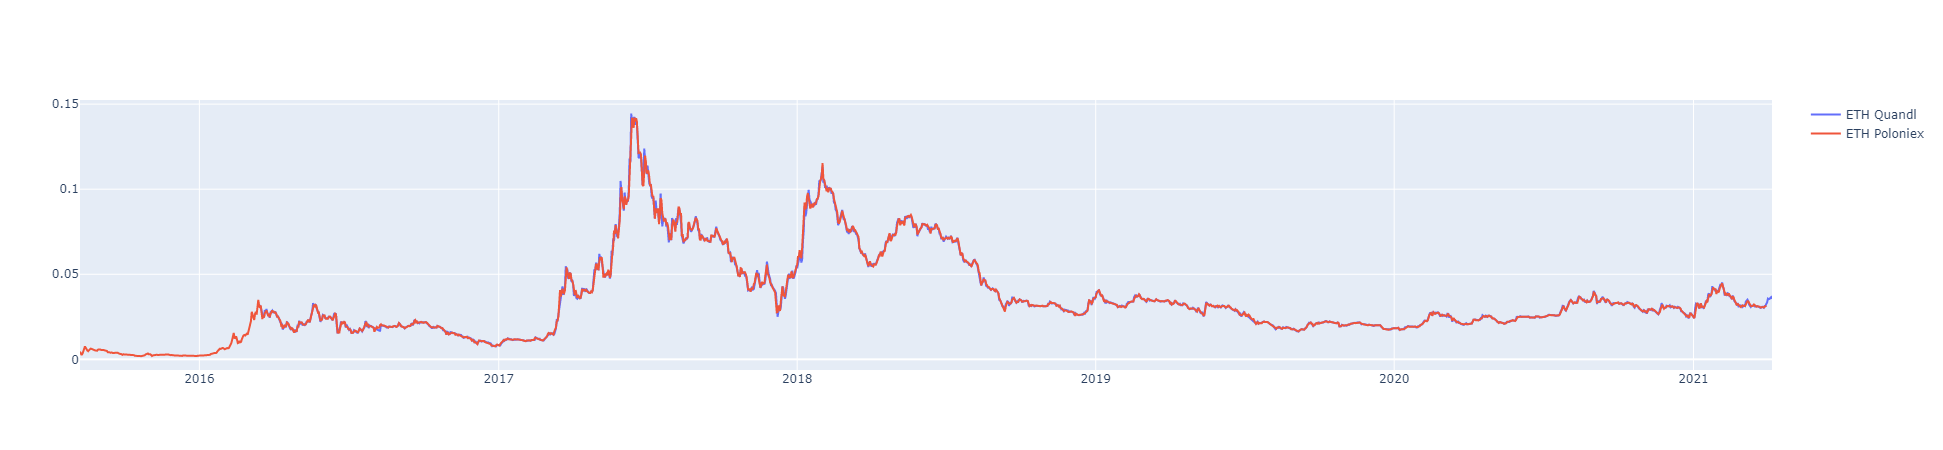

In [47]:
fig = go.Figure()

eth_quandl = df_altcoin_quandl_data[df_altcoin_quandl_data['Market']=='ETH']
eth_poloniex = df_altcoin_poloniex_data[df_altcoin_poloniex_data['Market']=='ETH']

fig.add_trace(go.Scatter(x=eth_quandl.index, y=eth_quandl['Last'],
                         mode='lines',
                         name='ETH Quandl'))

fig.add_trace(go.Scatter(x=eth_poloniex.index, y=eth_poloniex['weightedAverage'],
                         mode='lines',
                         name='ETH Poloniex'))

fig.show()

In [48]:
print(eth_quandl.shape)
print(eth_poloniex.shape)

(1808, 8)
(2063, 8)


In [49]:
print(len(set(df_altcoin_quandl_data['Market'])))
print(len(set(df_altcoin_poloniex_data['Market'])))

30
32


In [50]:
print(df_altcoin_quandl_data.isna().sum())
print(df_altcoin_poloniex_data.isna().sum())

High      0
Low       0
Mid       0
Last      0
Bid       0
Ask       0
Volume    0
Market    0
dtype: int64
high               0
low                0
open               0
close              0
volume             0
quoteVolume        0
weightedAverage    0
Market             0
dtype: int64


#### Take Poloniex for Altcoin data

In [51]:
df_altcoin_poloniex_data.columns = df_altcoin_poloniex_data.columns.str.title()
df_altcoin_poloniex_data = df_altcoin_poloniex_data.rename(columns={'Volume': 'Volume_BTC', 'Quotevolume': 'Volume_Market',  
                                                     'Weightedaverage': 'Weighted Price'})

df_altcoin_poloniex_data['Exchange'] = 'POLONIEX'
column_names_altcoin=['Open', 'High', 'Low', 'Close', 'Volume_BTC', 'Volume_Market', 'Weighted Price', 'Exchange', 'Market']
df_altcoin_poloniex_data = df_altcoin_poloniex_data.reindex(columns=column_names_altcoin)

df_altcoin_poloniex_data.tail()

Open          High           Low         Close  \
date                                                                 
2021-03-31  1.255000e-04  1.261500e-04  1.242100e-04  1.261500e-04   
2021-03-31  4.300000e-07  4.500000e-07  4.000000e-07  4.400000e-07   
2021-03-31  4.161090e-03  4.508000e-03  4.133010e-03  4.191210e-03   
2021-03-31  3.065820e-03  3.076980e-03  3.023070e-03  3.041090e-03   
2021-03-31  1.011000e-04  1.060200e-04  9.683000e-05  1.060200e-04   

            Volume_BTC  Volume_Market  Weighted Price  Exchange Market  
date                                                                    
2021-03-31    0.014222   1.130724e+02    1.257700e-04  POLONIEX    BNT  
2021-03-31    7.483935   1.753603e+07    4.200000e-07  POLONIEX     SC  
2021-03-31   29.322857   6.776518e+03    4.327120e-03  POLONIEX    XMR  
2021-03-31    0.792017   2.603453e+02    3.042170e-03  POLONIEX    DCR  
2021-03-31    1.016691   1.006703e+04    1.009900e-04  POLONIEX    LSK

### Inject Other relevant Data

In [52]:
# Get Bitcoin mining data

df_mining_data = get_quandl_data('BITCOINWATCH/MINING')
df_mining_data['Market'] = 'BTC'
df_mining_data['Source'] = 'BITCOINWATCH'
df_mining_data.tail()

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BITCOINWATCH-MINING.json from cache


Total BTC    Market Cap  Transactions last 24h  \
2021-04-02   16522800  950437719840                    NaN   
2021-04-03   16522800  960799167720                    NaN   
2021-04-04   16522800  972988037280                    NaN   
2021-04-05   16522800  956926223400                    NaN   
2021-04-06   16522800  932710407720                    NaN   

            Transactions avg. per hour  Bitcoins sent last 24h  \
2021-04-02                         NaN                     NaN   
2021-04-03                         NaN                     NaN   
2021-04-04                         NaN                     NaN   
2021-04-05                         NaN                     NaN   
2021-04-06                         NaN                     NaN   

            Bitcoins sent avg. per hour   Count  Blocks last 24h  \
2021-04-02                          NaN  481823                0   
2021-04-03                          NaN  481823                0   
2021-04-04                          NaN  481823                0   
2021-04-05                          NaN  481823                0   
2021-04-06                          NaN  481823                0   

            Blocks avg. per hour    Difficulty  Next Difficulty  \
2021-04-02                   0.0  923233068449     887736944047   
2021-04-03                   0.0  923233068449     887736944047   
2021-04-04                   0.0  923233068449     887736944047   
2021-04-05                   0.0  923233068449     887736944047   
2021-04-06                   0.0  923233068449     887736944047   

            Network Hashrate Terahashs  Network Hashrate PetaFLOPS Market  \
2021-04-02                  6354668.57                 80704290.84    BTC   
2021-04-03                  6354668.57                 80704290.84    BTC   
2021-04-04                  6354668.57                 80704290.84    BTC   
2021-04-05                  6354668.57                 80704290.84    BTC   
2021-04-06                  6354668.57                 80704290.84    BTC   

                  Source  
2021-04-02  BITCOINWATCH  
2021-04-03  BITCOINWATCH  
2021-04-04  BITCOINWATCH  
2021-04-05  BITCOINWATCH  
2021-04-06  BITCOINWATCH

In [53]:
tickers = {
    'Oil_Price': 'CL=F',
    'Gold_Price': 'GC=F',
    'SP500': '^GSPC',
    'DJI': '^DJI',
    'Nasdaq': '^IXIC',
    'Tesla': 'TSLA'
}

asset_list = []

for name, ticker in tickers.items():
    df = get_yfinance_data(ticker)
    df['Asset'] = name
    df['Symbol'] = re.sub(r'\W+', '', ticker)
    df['Source'] = 'YAHOO'
    asset_list.append(df)
    
df_asset_data = pd.concat(asset_list)


[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\CL_F.json from cache
[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\GC_F.json from cache
[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\_GSPC.json from cache
[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\_DJI.json from cache
[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\_IXIC.json from cache
[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\TSLA.json from cache


In [54]:
df_asset_data

Open        High         Low       Close   Adj Close  \
2000-08-23   31.950001   32.799999   31.950001   32.049999   32.049999   
2000-08-24   31.900000   32.240002   31.400000   31.629999   31.629999   
2000-08-25   31.700001   32.099998   31.320000   32.049999   32.049999   
2000-08-28   32.040001   32.919998   31.860001   32.869999   32.869999   
2000-08-29   32.820000   33.029999   32.560001   32.720001   32.720001   
...                ...         ...         ...         ...         ...   
2021-03-31  646.619995  672.000000  641.109985  667.929993  667.929993   
2021-04-01  688.369995  692.419983  659.419983  661.750000  661.750000   
2021-04-05  707.710022  708.159973  684.700012  691.049988  691.049988   
2021-04-06  690.299988  696.549988  681.369995  691.619995  691.619995   
2021-04-07  687.000000  691.380005  668.520020  670.969971  670.969971   

              Volume      Asset Symbol Source  
2000-08-23     79385  Oil_Price    CLF  YAHOO  
2000-08-24     72978  Oil_Price    CLF  YAHOO  
2000-08-25     44601  Oil_Price    CLF  YAHOO  
2000-08-28     46770  Oil_Price    CLF  YAHOO  
2000-08-29     49131  Oil_Price    CLF  YAHOO  
...              ...        ...    ...    ...  
2021-03-31  33337300      Tesla   TSLA  YAHOO  
2021-04-01  35298400      Tesla   TSLA  YAHOO  
2021-04-05  41842800      Tesla   TSLA  YAHOO  
2021-04-06  28234200      Tesla   TSLA  YAHOO  
2021-04-07  25933544      Tesla   TSLA  YAHOO  

[56445 rows x 9 columns]

## Organize Data

### Create Date Table

In [55]:
df_dates = create_date_table()
df_dates

DateID       Date   Week_day  Day  Month  Week  Quarter  Year
0      19000101 1900-01-01     Monday    1      1     1        1  1900
1      19000102 1900-01-02    Tuesday    2      1     1        1  1900
2      19000103 1900-01-03  Wednesday    3      1     1        1  1900
3      19000104 1900-01-04   Thursday    4      1     1        1  1900
4      19000105 1900-01-05     Friday    5      1     1        1  1900
...         ...        ...        ...  ...    ...   ...      ...   ...
73044  20991227 2099-12-27     Sunday   27     12    52        4  2099
73045  20991228 2099-12-28     Monday   28     12    53        4  2099
73046  20991229 2099-12-29    Tuesday   29     12    53        4  2099
73047  20991230 2099-12-30  Wednesday   30     12    53        4  2099
73048  20991231 2099-12-31   Thursday   31     12    53        4  2099

[73049 rows x 8 columns]

### Tranform DataFrames

<p><strong>Relevant Dataframes:</strong></p>
<ul style="line-height:180%">
    <li>BTC Data: df_btc_data</li>
    <li>Altcoin Data: df_altcoin_poloniex_data</li>
    <li>Fin Assets Data: df_asset_data</li>
    <li>Mining Data: df_mining_data</li>
    <li>Exchanges Data: df_cg_exchanges</li>
    <li>Markets Data: df_cg_markets</li>
    <li>Coingecko BTC Price Data: df_cg_btc_data</li>
    <li>Yahoo BTC Price Data: df_yahoo_btc_data</li>
    <li>Date Table: df_dates</li>
</ul>

In [56]:
# Create copies of the imported data that is being transformed

df_btc = df_btc_data.copy()
df_altcoin = df_altcoin_poloniex_data.copy()
df_fin_asset = df_asset_data.copy()
df_mining = df_mining_data.copy()
df_exchanges = df_cg_exchanges.copy()
df_markets = df_cg_markets.copy()


data_frames = {
    'BTC Data': df_btc,
    'Altcoin Data': df_altcoin,
    'Fin Assets Data': df_fin_asset,
    'Mining Data': df_mining,
    'Exchanges Data': df_exchanges,
    'Markets Data': df_markets,
    'Coingecko BTC Price Data': df_cg_btc_data,
    'Yahoo BTC Price Data': df_yahoo_btc_data,
    'Date Table': df_dates
}

In [57]:
data_frames_col_names = {}
for df_name, df in data_frames.items():
    data_frames_col_names[df_name] = df.columns
    

In [58]:
data_frames_col_names

{'BTC Data': Index(['Open', 'High', 'Low', 'Close', 'Volume_BTC', 'Volume_USD',
        'Weighted Price', 'Exchange', 'Market'],
       dtype='object'),
 'Altcoin Data': Index(['Open', 'High', 'Low', 'Close', 'Volume_BTC', 'Volume_Market',
        'Weighted Price', 'Exchange', 'Market'],
       dtype='object'),
 'Fin Assets Data': Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Asset',
        'Symbol', 'Source'],
       dtype='object'),
 'Mining Data': Index(['Total BTC', 'Market Cap', 'Transactions last 24h',
        'Transactions avg. per hour', 'Bitcoins sent last 24h',
        'Bitcoins sent avg. per hour', 'Count', 'Blocks last 24h',
        'Blocks avg. per hour', 'Difficulty', 'Next Difficulty',
        'Network Hashrate Terahashs', 'Network Hashrate PetaFLOPS', 'Market',
        'Source'],
       dtype='object'),
 'Exchanges Data': Index(['id', 'name', 'year_established', 'country', 'description', 'url',
        'image', 'has_trading_incentive', 'trust_score', '

In [59]:
# Check the existence of used exchanges in the full exchange list

exchanges_list_cg = pd.unique(df_exchanges['id'].str.upper())
exchanges_list_cg= np.append(exchanges_list_cg, ['YAHOO'])
exchanges_list_cg.sort()
exchanges_list_cg

exchanges_used = pd.unique(df_btc['Exchange'])
exchanges_used.sort()
print(f"{exchanges_list_cg}\n" \
      f"{exchanges_used}")
check_items(exchanges_list_cg, exchanges_used)

['AEX' 'ALTERDICE' 'BANCOR' 'BIBOX' 'BIDESK' 'BIGONE' 'BIKI' 'BINANCE'
 'BINANCE_US' 'BITBANK' 'BITCOIN_COM' 'BITFINEX' 'BITFLYER' 'BITFOREX'
 'BITGET' 'BITHUMB' 'BITHUMB_GLOBAL' 'BITKUB' 'BITMART' 'BITMAX'
 'BITOFFER' 'BITOPRO' 'BITPANDA' 'BITRUE' 'BITSO' 'BITSTAMP' 'BITTREX'
 'BIT_Z' 'BKEX' 'BLOCKCHAIN_COM' 'BTCBOX' 'BTCMARKETS' 'BTCTURK' 'BW'
 'CEX' 'CHANGELLY' 'COINBENE' 'COINCHECK' 'COINEAL' 'COINMARGIN' 'COINONE'
 'COINSBIT' 'COINTIGER' 'CRYPTOLOGY' 'CRYPTO_COM' 'DEXTRADE' 'DIGIFINEX'
 'EMIREX' 'ETOROX' 'EXMARKETS' 'EXMO' 'EXRATES' 'FATBTC' 'FINEXBOX'
 'FTX_SPOT' 'FTX_US' 'GATE' 'GDAX' 'GEMINI' 'GMO_JAPAN' 'GOPAX' 'HITBTC'
 'HOO' 'HUOBI' 'INDEPENDENT_RESERVE' 'INDODAX' 'ITBIT' 'KICKEX' 'KRAKEN'
 'KUCOIN' 'KUNA' 'LAKEBTC' 'LATOKEN' 'LBANK' 'LUNO' 'MAX_MAICOIN' 'MDEX'
 'MERCADO_BITCOIN' 'MXC' 'NICE_HASH' 'OCEANEX' 'OKCOIN' 'OKEX' 'OMGFIN'
 'P2PB2B' 'PARIBU' 'POLONIEX' 'PROBIT' 'QUOINE' 'SUSHISWAP' 'THODEX'
 'UNISWAP' 'UPBIT' 'VCC' 'VEBITCOIN' 'WAZIRX' 'WHITEBIT' 'XT' 'YAHOO'
 'ZAIF

True

In [60]:
# Check the existence of used altcoin syymbols in the full altcoin list

markets_list_cg = pd.unique(df_markets['symbol'].str.upper())
add_markets = np.unique(df_fin_asset['Symbol'])
markets_list_cg = np.append(markets_list_cg, add_markets)
markets_list_cg.sort()
markets_list_cg

markets_used = pd.unique(df_altcoin['Market'])
markets_used.sort()
print(f"{markets_list_cg}\n" \
      f"{markets_used}")
check_items(markets_list_cg, markets_used)

['AAVE' 'ADA' 'ALGO' 'AMP' 'ANKR' 'AR' 'ATOM' 'AVAX' 'BAT' 'BCH' 'BNB'
 'BNT' 'BSV' 'BTC' 'BTG' 'BTT' 'BUSD' 'CAKE' 'CDAI' 'CEL' 'CETH' 'CHSB'
 'CHZ' 'CLF' 'COMP' 'CRO' 'CUSDC' 'DAI' 'DASH' 'DCR' 'DENT' 'DGB' 'DJI'
 'DOGE' 'DOT' 'EGLD' 'ENJ' 'EOS' 'ETC' 'ETH' 'FEI' 'FIL' 'FLOW' 'FTM'
 'FTT' 'GCF' 'GRT' 'GSPC' 'HBAR' 'HBTC' 'HNT' 'HOT' 'HT' 'ICX' 'IXIC'
 'KCS' 'KSM' 'LEO' 'LINK' 'LSK' 'LTC' 'LUNA' 'MANA' 'MATIC' 'MIOTA' 'MKR'
 'NEAR' 'NEO' 'NEXO' 'NPXS' 'OKB' 'OMG' 'OMI' 'ONE' 'ONT' 'PUNDIX' 'QTUM'
 'RSR' 'RUNE' 'RVN' 'SC' 'SNX' 'SOL' 'STX' 'SUSHI' 'THETA' 'TRX' 'TSLA'
 'UMA' 'UNI' 'USDC' 'USDT' 'UST' 'VET' 'WAVES' 'WBTC' 'WIN' 'XEM' 'XLM'
 'XMR' 'XRP' 'XTZ' 'YFI' 'ZEC' 'ZIL' 'ZRX']
['AAVE' 'AMP' 'ATOM' 'BAT' 'BCH' 'BNT' 'DASH' 'DCR' 'DOGE' 'DOT' 'EOS'
 'ETC' 'ETH' 'LINK' 'LSK' 'LTC' 'MANA' 'MATIC' 'MKR' 'NEO' 'OMG' 'QTUM'
 'SC' 'SNX' 'TRX' 'WBTC' 'XEM' 'XMR' 'XRP' 'XTZ' 'ZEC' 'ZRX']


True

In [61]:
# Create ID Columns for Exchanges

exchange_mapping = {}
for exchange_id, exchange_value in enumerate(exchanges_list_cg):
    exchange_mapping.update({exchange_value:exchange_id+1})
    
value_mapper(df_exchanges, 'id', 'ExchangeID', exchange_mapping)
df_exchanges.head()

id          name  year_established                 country  \
0     binance       Binance            2017.0          Cayman Islands   
1        gdax  Coinbase Pro            2012.0           United States   
2      kraken        Kraken            2011.0           United States   
3    bitfinex      Bitfinex            2014.0  British Virgin Islands   
4  binance_us    Binance US            2019.0           United States   

  description                         url  \
0                https://www.binance.com/   
1                https://www.coinbase.com   
2              https://r.kraken.com/Q1m9x   
3                https://www.bitfinex.com   
4               https://www.binance.us/en   

                                               image has_trading_incentive  \
0  https://assets.coingecko.com/markets/images/52...                 False   
1  https://assets.coingecko.com/markets/images/23...                 False   
2  https://assets.coingecko.com/markets/images/29...                 False   
3  https://assets.coingecko.com/markets/images/4/...                 False   
4  https://assets.coingecko.com/markets/images/46...                 False   

   trust_score  trust_score_rank  trade_volume_24h_btc  \
0           10                 1         480499.839325   
1           10                 2          35861.241635   
2           10                 3          17501.815747   
3           10                 4          14231.383853   
4           10                 5           9224.040955   

   trade_volume_24h_btc_normalized  ExchangeID  
0                    480499.839325           8  
1                     35861.241635          58  
2                     17501.815747          69  
3                     14231.383853          12  
4                      9224.040955           9

In [62]:
# Create ID Columns for Markets

market_mapping = {}
for market_id, market_value in enumerate(markets_list_cg):
    market_mapping.update({market_value:market_id+1})

value_mapper(df_markets, 'symbol', 'MarketID', market_mapping)
df_markets.head()

id symbol          name  \
0      bitcoin    btc       Bitcoin   
1     ethereum    eth      Ethereum   
2  binancecoin    bnb  Binance Coin   
3       ripple    xrp           XRP   
4       tether   usdt        Tether   

                                               image  current_price  \
0  https://assets.coingecko.com/coins/images/1/la...   58019.000000   
1  https://assets.coingecko.com/coins/images/279/...    2064.580000   
2  https://assets.coingecko.com/coins/images/825/...     442.660000   
3  https://assets.coingecko.com/coins/images/44/l...       1.030000   
4  https://assets.coingecko.com/coins/images/325/...       0.999503   

      market_cap  market_cap_rank  fully_diluted_valuation  total_volume  \
0  1083818432047                1             1.218539e+12   45513950034   
1   238252506191                2                      NaN   25141764921   
2    68309910582                3             7.538254e+10    5776554736   
3    47253097218                4                      NaN    8780967070   
4    43883964993                5                      NaN   94413452141   

   high_24h  ...   max_supply       ath  ath_change_percentage  \
0  58848.00  ...   21000000.0  61712.00               -6.07839   
1   2110.40  ...          NaN   2153.08               -4.27161   
2    446.11  ...  170533651.9    446.11               -1.31045   
3      1.08  ...          NaN      3.40              -69.73184   
4      1.00  ...          NaN      1.32              -24.45724   

                   ath_date        atl  atl_change_percentage  \
0  2021-03-13T20:49:26.606Z  67.810000           8.537653e+04   
1  2021-04-06T01:14:31.985Z   0.432979           4.759312e+05   
2  2021-04-09T14:13:55.939Z   0.039818           1.105593e+06   
3  2018-01-07T00:00:00.000Z   0.002686           3.819371e+04   
4  2018-07-24T00:00:00.000Z   0.572521           7.457922e+01   

                   atl_date  \
0  2013-07-06T00:00:00.000Z   
1  2015-10-20T00:00:00.000Z   
2  2017-10-19T00:00:00.000Z   
3  2014-05-22T00:00:00.000Z   
4  2015-03-02T00:00:00.000Z   

                                                 roi  \
0                                               None   
1  {'times': 46.572425198398, 'currency': 'btc', ...   
2                                               None   
3                                               None   
4                                               None   

               last_updated  MarketID  
0  2021-04-09T23:36:47.316Z        14  
1  2021-04-09T23:36:27.572Z        40  
2  2021-04-09T23:35:43.726Z        11  
3  2021-04-09T23:36:35.089Z       101  
4  2021-04-09T23:06:44.237Z        92  

[5 rows x 27 columns]

In [63]:
# Map the Exchange and Market IDs to the BTC, Altcoin and Fin Asset Data

value_mapper(df_btc, 'Exchange', 'ExchangeID', exchange_mapping)
value_mapper(df_btc, 'Market', 'MarketID', market_mapping)

value_mapper(df_altcoin, 'Exchange', 'ExchangeID', exchange_mapping)
value_mapper(df_altcoin, 'Market', 'MarketID', market_mapping)

value_mapper(df_fin_asset, 'Source', 'ExchangeID', exchange_mapping)
value_mapper(df_fin_asset, 'Symbol', 'MarketID', market_mapping)

value_mapper(df_mining, 'Market', 'MarketID', market_mapping)

print(df_btc.head())
print(df_altcoin.head())
print(df_fin_asset.head())
print(df_mining.head())

                 Open       High        Low      Close  Volume_BTC  \
2014-01-07  874.67040  892.06753  810.00000  810.00000   15.622378   
2014-01-08  810.00000  899.84281  788.00000  824.98287   19.182756   
2014-01-09  825.56345  870.00000  807.42084  841.86934    8.158335   
2014-01-10  839.99000  857.34056  817.00000  857.33056    8.024510   
2014-01-11  858.20000  918.05471  857.16554  899.84105   18.748285   

              Volume_USD  Weighted Price Exchange Market  ExchangeID  MarketID  
2014-01-07  13151.472844      841.835522   KRAKEN    BTC          69        14  
2014-01-08  16097.329584      839.156269   KRAKEN    BTC          69        14  
2014-01-09   6784.249982      831.572913   KRAKEN    BTC          69        14  
2014-01-10   6780.220188      844.938794   KRAKEN    BTC          69        14  
2014-01-11  16698.566929      890.671709   KRAKEN    BTC          69        14  
                Open      High       Low     Close  Volume_BTC  Volume_Market  \
date        

##### Create Mapping for subsetting the Data as a preparation to load into the Sqlite DB

In [64]:
data_frames_col_translate = {
    'BTC Data': [
        {
            'Open': 'Open', 
            'High': 'High', 
            'Low': 'Low', 
            'Close': 'Close', 
            'Volume_BTC': 'Volume_BTC', 
            'Volume_USD': 'Volume_USD',
            'Weighted Price': 'WeightedPrice', 
            'MarketID': 'MarketID',
            'ExchangeID': 'ExchangeID', 
            'Date': 'Date'
        }],
    'Altcoin Data': [
        {
            'Open': 'Open', 
            'High': 'High', 
            'Low': 'Low', 
            'Close': 'Close', 
            'Volume_BTC': 'Volume_BTC',
            'Volume_Market': 'Volume_Market', 
            'Weighted Price': 'WeightedPrice', 
            'MarketID': 'MarketID',
            'ExchangeID': 'ExchangeID', 
            'Date': 'Date'
        }],
    'Fin Assets Data': [
        {
            'Open': 'Open', 
            'High': 'High', 
            'Low': 'Low', 
            'Close': 'Close', 
            'Adj Close': 'AdjClose', 
            'Volume': 'Volume', 
            'Asset': 'Asset',
            'Symbol': 'Symbol',
            'Source': 'Source',
            'MarketID': 'MarketID',
            'ExchangeID': 'ExchangeID',
            'Date': 'Date'
        }],
    'Mining Data': [
        {
            'Total BTC': 'Total_BTC', 
            'Market Cap': 'MarketCap', 
            'Transactions last 24h': 'TR_24h',
            'Transactions avg. per hour': 'TR_Avg_h', 
            'Bitcoins sent last 24h': 'BTC_Sent_24h',
            'Bitcoins sent avg. per hour': 'BTC_Sent_Avg_h', 
            'Count': 'BTC_Count', 
            'Blocks last 24h': 'Blocks_24h',
            'Blocks avg. per hour': 'Blocks_Avg_h', 
            'Difficulty': 'Difficulty', 
            'Next Difficulty': 'Next_Difficulty',
            'Network Hashrate Terahashs': 'Hashrate_Tera', 
            'Network Hashrate PetaFLOPS': 'Hashrate_Peta',
            'MarketID': 'MarketID',
            'Date': 'Date'
        }],
    'Exchanges Data': [
        {
            'ExchangeID': 'ExchangeID', 
            'id': 'Exchange',
            'name': 'ExchangeName', 
            'year_established': 'Year_Est', 
            'country': 'Country', 
            'has_trading_incentive': 'Trading_Inc',
            'trust_score': 'Trust_Score',
            'trust_score_rank': 'Rank_Trust',
            'trade_volume_24h_btc': 'Trade_Vol_24h',
            'trade_volume_24h_btc_normalized': 'Norm_Trade_Vol'
        }],
    'Markets Data': [
        {
            'MarketID': 'MarketID',
            'name': 'Market',
            'symbol': 'Symbol',
            'id': 'MarketName',
            'market_cap': 'MarketCap',
            'market_cap_rank': 'Rank_MarketCap',
            'total_volume': 'Total_Volume',
            'total_supply': 'Total_Supply',
            'max_supply': 'Max_Supply'
        }],
     'Coingecko BTC Price Data': [
         {
             'market_cap': 'MarketCap',
             'price': 'Close', 
             'volume': 'Volume'
         }],
     'Yahoo BTC Price Data': [
         {
             'High': 'High', 
             'Low': 'Low', 
             'Open': 'Open', 
             'Close': 'Close', 
             'Volume': 'Volume', 
             'Adj Close': 'Adj Close'
         }],
    'Date Table': [
        {
            'Date': 'Date', 
            'Week_day': 'Week_day', 
            'Day': 'Day', 
            'Month': 'Month', 
            'Week': 'Week', 
            'Quarter': 'Quarter',
            'Year': 'Year'
        }]
}

### Prepocessed Data

In [65]:
# Preprocess Data for SQL DB load

df_btc_prep = sql_preprocess(df_btc, 'BTC Data', data_frames_col_translate)
df_altcoin_prep = sql_preprocess(df_altcoin, 'Altcoin Data', data_frames_col_translate)
df_fin_asset_prep = sql_preprocess(df_fin_asset, 'Fin Assets Data', data_frames_col_translate)
df_mining_prep = sql_preprocess(df_mining, 'Mining Data', data_frames_col_translate)
df_exchanges_prep = sql_preprocess(df_exchanges, 'Exchanges Data', data_frames_col_translate)
df_markets_prep = sql_preprocess(df_markets, 'Markets Data', data_frames_col_translate)
df_dates_prep = sql_preprocess(df_dates, 'Date Table', data_frames_col_translate)

# Additional manual preprocessing

df_markets_prep = df_markets_prep.drop('Date', axis=1)
df_exchanges_prep = df_exchanges_prep.drop('Date', axis=1)
df_exchanges_prep['Trading_Inc'] = df_exchanges_prep['Trading_Inc'].replace({True: 1, False: 0})




In [66]:
df_exchanges_prep

Exchange  ExchangeName  Year_Est                 Country  Trading_Inc  \
0      binance       Binance    2017.0          Cayman Islands          0.0   
1         gdax  Coinbase Pro    2012.0           United States          0.0   
2       kraken        Kraken    2011.0           United States          0.0   
3     bitfinex      Bitfinex    2014.0  British Virgin Islands          0.0   
4   binance_us    Binance US    2019.0           United States          0.0   
..         ...           ...       ...                     ...          ...   
95   vebitcoin     Vebitcoin    2017.0                  Turkey          0.0   
96     exrates       Exrates    2016.0                 Estonia          0.0   
97  coinmargin    CoinMargin    2020.0                Malaysia          0.0   
98      kickex        KickEX    2020.0                 Estonia          0.0   
99   gmo_japan     GMO Japan       NaN                   Japan          0.0   

    Trust_Score  Rank_Trust  Trade_Vol_24h  Norm_Trade_Vol  ExchangeID  
0            10           1  480499.839325   480499.839325           8  
1            10           2   35861.241635    35861.241635          58  
2            10           3   17501.815747    17501.815747          69  
3            10           4   14231.383853    14231.383853          12  
4            10           5    9224.040955     9224.040955           9  
..          ...         ...            ...             ...         ...  
95            6          96    1103.321343     1103.321343          95  
96            6          97     763.415562      763.415562          52  
97            6          98     720.003359      720.003359          40  
98            6          99     700.003214      700.003214          68  
99            6         100     665.221143      665.221143          60  

[100 rows x 10 columns]

### Create DB and load data

In [67]:
engine = db.create_engine('sqlite:///crypto.db', echo=True)
meta = db.MetaData(engine)

with engine.connect() as con:
    con.execute('DROP TABLE IF EXISTS BTC_Data;')
    con.execute('DROP TABLE IF EXISTS Altcoin_Data;')
    con.execute('DROP TABLE IF EXISTS Fin_Assets_Data;')
    con.execute('DROP TABLE IF EXISTS Mining_Data;')
    con.execute('DROP TABLE IF EXISTS Markets;')
    con.execute('DROP TABLE IF EXISTS Exchanges;')
    con.execute('DROP TABLE IF EXISTS Dates_Table;')
    con.close()
        

2021-04-10 01:39:09,041 INFO sqlalchemy.engine.Engine DROP TABLE IF EXISTS BTC_Data;
2021-04-10 01:39:09,042 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-04-10 01:39:09,054 INFO sqlalchemy.engine.Engine COMMIT
2021-04-10 01:39:09,055 INFO sqlalchemy.engine.Engine DROP TABLE IF EXISTS Altcoin_Data;
2021-04-10 01:39:09,056 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-04-10 01:39:09,069 INFO sqlalchemy.engine.Engine COMMIT
2021-04-10 01:39:09,070 INFO sqlalchemy.engine.Engine DROP TABLE IF EXISTS Fin_Assets_Data;
2021-04-10 01:39:09,070 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-04-10 01:39:09,082 INFO sqlalchemy.engine.Engine COMMIT
2021-04-10 01:39:09,083 INFO sqlalchemy.engine.Engine DROP TABLE IF EXISTS Mining_Data;
2021-04-10 01:39:09,083 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-04-10 01:39:09,093 INFO sqlalchemy.engine.Engine COMMIT
2021-04-10 01:39:09,094 INFO sqlalchemy.engine.Engine DROP TABLE IF EXISTS Markets;
2021-04-10 01:39:09,095 INFO sqlalchemy.engine.Eng

In [68]:
engine = db.create_engine('sqlite:///crypto.db', echo=True)
meta = db.MetaData(engine)

with engine.connect() as con:
    con.execute('''
        CREATE TABLE IF NOT EXISTS BTC_Data
              (
                ID INT PRIMARY KEY,
                Open REAL NULL DEFAULT 0,
                High REAL NULL DEFAULT 0,
                Low REAL NULL DEFAULT 0,
                Close REAL NULL DEFAULT 0,
                WeightedPrice REAL NULL DEFAULT 0,
                Volume_USD REAL NULL DEFAULT 0,
                Volume_BTC REAL NULL DEFAULT 0,
                Currency VARCHAR(5) NULL DEFAULT "USD",
                MarketID INT NOT NULL,
                ExchangeID INT NOT NULL,
                Date DATE NOT NULL,
                FOREIGN KEY(MarketID) REFERENCES Markets(MarketID) ON DELETE CASCADE,
                FOREIGN KEY(ExchangeID) REFERENCES Exchanges(ExchangeID) ON DELETE CASCADE,
                FOREIGN KEY(Date) REFERENCES Dates_Table(Date) ON DELETE CASCADE
                          
              );''')


2021-04-10 01:39:09,154 INFO sqlalchemy.engine.Engine 
        CREATE TABLE IF NOT EXISTS BTC_Data
              (
                ID INT PRIMARY KEY,
                Open REAL NULL DEFAULT 0,
                High REAL NULL DEFAULT 0,
                Low REAL NULL DEFAULT 0,
                Close REAL NULL DEFAULT 0,
                WeightedPrice REAL NULL DEFAULT 0,
                Volume_USD REAL NULL DEFAULT 0,
                Volume_BTC REAL NULL DEFAULT 0,
                Currency VARCHAR(5) NULL DEFAULT "USD",
                MarketID INT NOT NULL,
                ExchangeID INT NOT NULL,
                Date DATE NOT NULL,
                FOREIGN KEY(MarketID) REFERENCES Markets(MarketID) ON DELETE CASCADE,
                FOREIGN KEY(ExchangeID) REFERENCES Exchanges(ExchangeID) ON DELETE CASCADE,
                FOREIGN KEY(Date) REFERENCES Dates_Table(Date) ON DELETE CASCADE
                          
              );
2021-04-10 01:39:09,154 INFO sqlalchemy.engine.Engine [raw 

In [69]:
engine = db.create_engine('sqlite:///crypto.db', echo=True)
meta = db.MetaData(engine)

with engine.connect() as con:
    con.execute('''
        CREATE TABLE IF NOT EXISTS Altcoin_Data
              (
                ID INT PRIMARY KEY,
                Open REAL NULL DEFAULT 0,
                High REAL NULL DEFAULT 0,
                Low REAL NULL DEFAULT 0,
                Close REAL NULL DEFAULT 0,
                WeightedPrice REAL NULL DEFAULT 0,
                Volume_Market REAL NULL DEFAULT 0,
                Volume_BTC REAL NULL DEFAULT 0,
                MarketID INT NOT NULL,
                ExchangeID INT NOT NULL,
                Date DATE NOT NULL,
                FOREIGN KEY(MarketID) REFERENCES Markets(MarketID) ON DELETE CASCADE,
                FOREIGN KEY(ExchangeID) REFERENCES Exchanges(ExchangeID) ON DELETE CASCADE,
                FOREIGN KEY(Date) REFERENCES Dates_Table(Date) ON DELETE CASCADE
                          
              ); ''')
    con.close()

2021-04-10 01:39:09,186 INFO sqlalchemy.engine.Engine 
        CREATE TABLE IF NOT EXISTS Altcoin_Data
              (
                ID INT PRIMARY KEY,
                Open REAL NULL DEFAULT 0,
                High REAL NULL DEFAULT 0,
                Low REAL NULL DEFAULT 0,
                Close REAL NULL DEFAULT 0,
                WeightedPrice REAL NULL DEFAULT 0,
                Volume_Market REAL NULL DEFAULT 0,
                Volume_BTC REAL NULL DEFAULT 0,
                MarketID INT NOT NULL,
                ExchangeID INT NOT NULL,
                Date DATE NOT NULL,
                FOREIGN KEY(MarketID) REFERENCES Markets(MarketID) ON DELETE CASCADE,
                FOREIGN KEY(ExchangeID) REFERENCES Exchanges(ExchangeID) ON DELETE CASCADE,
                FOREIGN KEY(Date) REFERENCES Dates_Table(Date) ON DELETE CASCADE
                          
              ); 
2021-04-10 01:39:09,186 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-04-10 01:39:09,196 INFO sqlalchemy.

In [70]:
engine = db.create_engine('sqlite:///crypto.db', echo=True)
meta = db.MetaData(engine)

with engine.connect() as con:
    con.execute('''
        CREATE TABLE IF NOT EXISTS Fin_Assets_Data
              (
                ID INT PRIMARY KEY,
                Open REAL NULL DEFAULT 0,
                High REAL NULL DEFAULT 0,
                Low REAL NULL DEFAULT 0,
                Close REAL NULL DEFAULT 0,
                AdjClose REAL NULL DEFAULT 0,
                Volume REAL NULL DEFAULT 0,
                Asset VARCHAR(50) NULL,
                Symbol VARCHAR(10) NULL,
                Source VARCHAR(10) NULL,
                MarketID INT NOT NULL,
                ExchangeID INT NOT NULL,
                Date DATE NOT NULL,
                FOREIGN KEY(MarketID) REFERENCES Markets(MarketID) ON DELETE CASCADE,
                FOREIGN KEY(ExchangeID) REFERENCES Exchanges(ExchangeID) ON DELETE CASCADE,
                FOREIGN KEY(Date) REFERENCES Dates_Table(Date) ON DELETE CASCADE
                          
              ); ''')
    con.close()

2021-04-10 01:39:09,217 INFO sqlalchemy.engine.Engine 
        CREATE TABLE IF NOT EXISTS Fin_Assets_Data
              (
                ID INT PRIMARY KEY,
                Open REAL NULL DEFAULT 0,
                High REAL NULL DEFAULT 0,
                Low REAL NULL DEFAULT 0,
                Close REAL NULL DEFAULT 0,
                AdjClose REAL NULL DEFAULT 0,
                Volume REAL NULL DEFAULT 0,
                Asset VARCHAR(50) NULL,
                Symbol VARCHAR(10) NULL,
                Source VARCHAR(10) NULL,
                MarketID INT NOT NULL,
                ExchangeID INT NOT NULL,
                Date DATE NOT NULL,
                FOREIGN KEY(MarketID) REFERENCES Markets(MarketID) ON DELETE CASCADE,
                FOREIGN KEY(ExchangeID) REFERENCES Exchanges(ExchangeID) ON DELETE CASCADE,
                FOREIGN KEY(Date) REFERENCES Dates_Table(Date) ON DELETE CASCADE
                          
              ); 
2021-04-10 01:39:09,218 INFO sqlalchemy.en

In [71]:
engine = db.create_engine('sqlite:///crypto.db', echo=True)
meta = db.MetaData(engine)

with engine.connect() as con:
    con.execute('''
        CREATE TABLE IF NOT EXISTS Mining_Data
              (
                ID INT PRIMARY KEY,
                Total_BTC INT NULL DEFAULT 0,
                MarketCap INT NULL DEFAULT 0,
                TR_24h REAL NULL DEFAULT 0,
                TR_Avg_h REAL NULL DEFAULT 0,
                BTC_Sent_24h REAL NULL DEFAULT 0,
                BTC_Sent_Avg_h REAL NULL DEFAULT 0,
                BTC_Count INT NULL DEFAULT 0,
                Blocks_24h INT NULL DEFAULT 0,
                Blocks_Avg_h REAL NULL DEFAULT 0,
                Difficulty INT NULL DEFAULT 0,
                Next_Difficulty INT NULL DEFAULT 0,
                Hashrate_Tera REAL NULL DEFAULT 0,
                Hashrate_Peta REAL NULL DEFAULT 0,
                MarketID INT NOT NULL,
                Date DATE NOT NULL,
                FOREIGN KEY(MarketID) REFERENCES Markets(MarketID) ON DELETE CASCADE,
                FOREIGN KEY(Date) REFERENCES Dates_Table(Date) ON DELETE CASCADE
                          
              ); ''')
    con.close()

2021-04-10 01:39:09,251 INFO sqlalchemy.engine.Engine 
        CREATE TABLE IF NOT EXISTS Mining_Data
              (
                ID INT PRIMARY KEY,
                Total_BTC INT NULL DEFAULT 0,
                MarketCap INT NULL DEFAULT 0,
                TR_24h REAL NULL DEFAULT 0,
                TR_Avg_h REAL NULL DEFAULT 0,
                BTC_Sent_24h REAL NULL DEFAULT 0,
                BTC_Sent_Avg_h REAL NULL DEFAULT 0,
                BTC_Count INT NULL DEFAULT 0,
                Blocks_24h INT NULL DEFAULT 0,
                Blocks_Avg_h REAL NULL DEFAULT 0,
                Difficulty INT NULL DEFAULT 0,
                Next_Difficulty INT NULL DEFAULT 0,
                Hashrate_Tera REAL NULL DEFAULT 0,
                Hashrate_Peta REAL NULL DEFAULT 0,
                MarketID INT NOT NULL,
                Date DATE NOT NULL,
                FOREIGN KEY(MarketID) REFERENCES Markets(MarketID) ON DELETE CASCADE,
                FOREIGN KEY(Date) REFERENCES Dates_Table(

In [72]:
engine = db.create_engine('sqlite:///crypto.db', echo=True)
meta = db.MetaData(engine)

with engine.connect() as con:
    con.execute('''
        CREATE TABLE IF NOT EXISTS Markets
              (
                MarketID INT PRIMARY KEY,
                Market VARCHAR(50) NOT NULL,
                Symbol VARCHAR(10) NOT NULL,
                MarketName VARCHAR(50) NULL,
                MarketCap INT NULL DEFAULT 0,
                Rank_MarketCap INT NOT NULL,
                Total_Volume INT NULL DEFAULT 0,
                Total_Supply INT NULL DEFAULT 0,
                Max_Supply INT NULL DEFAULT 0
                          
              ); ''')
    con.close()

2021-04-10 01:39:09,281 INFO sqlalchemy.engine.Engine 
        CREATE TABLE IF NOT EXISTS Markets
              (
                MarketID INT PRIMARY KEY,
                Market VARCHAR(50) NOT NULL,
                Symbol VARCHAR(10) NOT NULL,
                MarketName VARCHAR(50) NULL,
                MarketCap INT NULL DEFAULT 0,
                Rank_MarketCap INT NOT NULL,
                Total_Volume INT NULL DEFAULT 0,
                Total_Supply INT NULL DEFAULT 0,
                Max_Supply INT NULL DEFAULT 0
                          
              ); 
2021-04-10 01:39:09,282 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-04-10 01:39:09,291 INFO sqlalchemy.engine.Engine COMMIT


In [73]:
engine = db.create_engine('sqlite:///crypto.db', echo=True)
meta = db.MetaData(engine)

with engine.connect() as con:
    con.execute('''
        CREATE TABLE IF NOT EXISTS Exchanges
              (
                ExchangeID INT PRIMARY KEY,
                Exchange VARCHAR(50) NOT NULL,
                ExchangeName VARCHAR(50) NULL,
                Year_Est REAL NULL,
                Country VARCHAR(50) NULL,
                Trading_Inc REAL NULL,
                Trust_Score INT NOT NULL,
                Rank_Trust INT NOT NULL,
                Trade_Vol_24h REAL NULL DEFAULT 0,
                Norm_Trade_Vol REAL NULL DEFAULT 0
                          
              ); ''')
    con.close()

2021-04-10 01:39:09,313 INFO sqlalchemy.engine.Engine 
        CREATE TABLE IF NOT EXISTS Exchanges
              (
                ExchangeID INT PRIMARY KEY,
                Exchange VARCHAR(50) NOT NULL,
                ExchangeName VARCHAR(50) NULL,
                Year_Est REAL NULL,
                Country VARCHAR(50) NULL,
                Trading_Inc REAL NULL,
                Trust_Score INT NOT NULL,
                Rank_Trust INT NOT NULL,
                Trade_Vol_24h REAL NULL DEFAULT 0,
                Norm_Trade_Vol REAL NULL DEFAULT 0
                          
              ); 
2021-04-10 01:39:09,314 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-04-10 01:39:09,323 INFO sqlalchemy.engine.Engine COMMIT


In [74]:
engine = db.create_engine('sqlite:///crypto.db', echo=True)
meta = db.MetaData(engine)

with engine.connect() as con:
    con.execute('''
        CREATE TABLE IF NOT EXISTS Dates_Table
              (
                Date DATE PRIMARY KEY,
                Week_day VARCHAR(50) NOT NULL,
                Day INT NOT NULL,
                Month INT NOT NULL,
                Week INT NOT NULL,
                Quarter INT NOT NULL,
                Year INT NOT NULL
                          
              ); ''')
    con.close()

2021-04-10 01:39:09,345 INFO sqlalchemy.engine.Engine 
        CREATE TABLE IF NOT EXISTS Dates_Table
              (
                Date DATE PRIMARY KEY,
                Week_day VARCHAR(50) NOT NULL,
                Day INT NOT NULL,
                Month INT NOT NULL,
                Week INT NOT NULL,
                Quarter INT NOT NULL,
                Year INT NOT NULL
                          
              ); 
2021-04-10 01:39:09,346 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-04-10 01:39:09,356 INFO sqlalchemy.engine.Engine COMMIT


In [75]:
inspector = db.inspect(engine)
table_names = inspector.get_table_names()
table_names

2021-04-10 01:39:09,377 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2021-04-10 01:39:09,378 INFO sqlalchemy.engine.Engine [raw sql] ()


['Altcoin_Data',
 'BTC_Data',
 'Dates_Table',
 'Exchanges',
 'Fin_Assets_Data',
 'Markets',
 'Mining_Data']

In [76]:
for table in table_names:
    load_to_sql(table)

2021-04-10 01:39:09,393 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Altcoin_Data")
2021-04-10 01:39:09,393 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-04-10 01:39:09,395 INFO sqlalchemy.engine.Engine PRAGMA main.table_info("Altcoin_Data")
2021-04-10 01:39:09,396 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-04-10 01:39:09,397 INFO sqlalchemy.engine.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2021-04-10 01:39:09,397 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-04-10 01:39:09,398 INFO sqlalchemy.engine.Engine PRAGMA main.table_xinfo("Altcoin_Data")
2021-04-10 01:39:09,399 INFO sqlalchemy.engine.Engine [raw sql] ()
2021-04-10 01:39:09,401 INFO sqlalchemy.engine.Engine SELECT sql FROM  (SELECT * FROM sqlite_master UNION ALL   SELECT * FROM sqlite_temp_master) WHERE name = ? AND type = 'table'
2021-04-10 01:39:09,402 INFO sqlalchemy.engine.Engine [raw sql] ('Altcoin_Data',)
2021-04-10 01:39:09,403 INFO sqlalchemy.engine.Engine PRAGMA main.foreig

In [77]:
engine = db.create_engine('sqlite:///crypto.db', echo=True)

with engine.connect() as con:
    df_sql = pd.read_sql_query("""
    SELECT * 
    FROM BTC_DATA;
        """, con)
    con.close()

2021-04-10 01:39:11,382 INFO sqlalchemy.engine.Engine 
    SELECT * 
    FROM BTC_DATA;
        
2021-04-10 01:39:11,383 INFO sqlalchemy.engine.Engine [raw sql] ()


In [78]:
df_sql

Date          Open          High           Low  \
0      2014-01-07 00:00:00.000000    874.670400    892.067530    810.000000   
1      2014-01-08 00:00:00.000000    810.000000    899.842810    788.000000   
2      2014-01-09 00:00:00.000000    825.563450    870.000000    807.420840   
3      2014-01-10 00:00:00.000000    839.990000    857.340560    817.000000   
4      2014-01-11 00:00:00.000000    858.200000    918.054710    857.165540   
...                           ...           ...           ...           ...   
16374  2021-03-27 00:00:00.000000  55008.350978  56645.325460  53967.742633   
16375  2021-03-28 00:00:00.000000  55828.000000  56517.750699  54700.000000   
16376  2021-03-29 00:00:00.000000  55769.134151  58332.142365  54940.245881   
16377  2021-03-30 00:00:00.000000  57614.000000  59360.000000  57085.000000   
16378  2021-03-31 00:00:00.000000  58748.000000  59782.490733  56846.531521   

              Close   Volume_BTC    Volume_USD  WeightedPrice  ExchangeID  \
0        810.000000    15.622378  1.315147e+04     841.835522          69   
1        824.982870    19.182756  1.609733e+04     839.156269          69   
2        841.869340     8.158335  6.784250e+03     831.572913          69   
3        857.330560     8.024510  6.780220e+03     844.938794          69   
4        899.841050    18.748285  1.669857e+04     890.671709          69   
...             ...          ...           ...            ...         ...   
16374  55855.274815   521.355309  2.880248e+07   55245.398905          87   
16375  55773.962120   426.410099  2.379101e+07   55793.739993          87   
16376  57620.809447   786.820766  4.498012e+07   57166.920136          87   
16377  58748.000000   508.525830  2.964910e+07   58304.022460          87   
16378  58743.337525  1025.147455  6.003219e+07   58559.565409          87   

       MarketID  
0            14  
1            14  
2            14  
3            14  
4            14  
...         ...  
16374        14  
16375        14  
16376        14  
16377        14  
16378        14  

[16379 rows x 10 columns]

## Data Wrangling

### BTC Dataset Preparation using Pandas

In [79]:
btc_data_prepared = df_btc_prep.merge(df_exchanges_prep[['Exchange', 'ExchangeID']], how='left', 
                                      left_on='ExchangeID', right_on='ExchangeID').drop(columns=['ExchangeID'])
btc_data_prepared['Exchange'] = btc_data_prepared['Exchange'].str.upper()
btc_data_prepared['Month'] = btc_data_prepared['Date'].dt.month_name()
btc_data_prepared['Year'] = btc_data_prepared['Date'].dt.year
btc_data_prepared = btc_data_prepared[['Date', 'WeightedPrice', 'Volume_BTC', 'Exchange', 'Year', 'Month']]
btc_data_prepared.tail()

Date  WeightedPrice   Volume_BTC  Exchange  Year  Month
16374 2021-03-27   55245.398905   521.355309  POLONIEX  2021  March
16375 2021-03-28   55793.739993   426.410099  POLONIEX  2021  March
16376 2021-03-29   57166.920136   786.820766  POLONIEX  2021  March
16377 2021-03-30   58304.022460   508.525830  POLONIEX  2021  March
16378 2021-03-31   58559.565409  1025.147455  POLONIEX  2021  March

In [80]:
btc_data_prepared.isna().sum()

Date             0
WeightedPrice    0
Volume_BTC       0
Exchange         0
Year             0
Month            0
dtype: int64

In [81]:
btc_data_prepared.loc[(btc_data_prepared==0).any(axis=1)]

Date  WeightedPrice  Volume_BTC  Exchange  Year      Month
132   2014-05-19       0.000000         0.0    KRAKEN  2014        May
211   2014-08-06       0.000000         0.0    KRAKEN  2014     August
231   2014-08-26       0.000000         0.0    KRAKEN  2014     August
239   2014-09-03       0.000000         0.0    KRAKEN  2014  September
241   2014-09-05       0.000000         0.0    KRAKEN  2014  September
...          ...            ...         ...       ...   ...        ...
14127 2016-11-26       0.000000         0.0      EXMO  2016   November
14128 2016-11-27       0.000000         0.0      EXMO  2016   November
14129 2016-11-28       0.000000         0.0      EXMO  2016   November
14130 2016-11-29       0.000000         0.0      EXMO  2016   November
14192 2015-04-06     254.696222         0.0  POLONIEX  2015      April

[432 rows x 6 columns]

In [82]:
btc_data_prepared = btc_data_prepared.replace(0, np.nan)

In [83]:
btc_data_prepared.isna().sum()

Date               0
WeightedPrice    431
Volume_BTC       432
Exchange           0
Year               0
Month              0
dtype: int64

In [84]:
btc_data_prepared[(btc_data_prepared['Date'].dt.year==2014) & (btc_data_prepared['Exchange']=='KRAKEN') 
                  & (btc_data_prepared.index.to_series().between(211, 240))]

Date  WeightedPrice  Volume_BTC Exchange  Year      Month
211 2014-08-06            NaN         NaN   KRAKEN  2014     August
212 2014-08-07     586.434789   16.810147   KRAKEN  2014     August
213 2014-08-08     589.632736    0.427263   KRAKEN  2014     August
214 2014-08-09     583.327123    7.804087   KRAKEN  2014     August
215 2014-08-10     588.587698    1.658715   KRAKEN  2014     August
216 2014-08-11     586.377662    0.477914   KRAKEN  2014     August
217 2014-08-12     570.760559    3.819120   KRAKEN  2014     August
218 2014-08-13     561.806115    4.349212   KRAKEN  2014     August
219 2014-08-14     514.094034   31.828217   KRAKEN  2014     August
220 2014-08-15     520.744726   23.957200   KRAKEN  2014     August
221 2014-08-16     503.524564   11.010709   KRAKEN  2014     August
222 2014-08-17     508.967447    2.651337   KRAKEN  2014     August
223 2014-08-18     480.536020   28.549676   KRAKEN  2014     August
224 2014-08-19     477.094721   77.755792   KRAKEN  2014     August
225 2014-08-20     499.605746   13.530526   KRAKEN  2014     August
226 2014-08-21     508.298394    4.621391   KRAKEN  2014     August
227 2014-08-22     529.945438    9.620586   KRAKEN  2014     August
228 2014-08-23     516.571301    0.563896   KRAKEN  2014     August
229 2014-08-24     524.879990    0.700000   KRAKEN  2014     August
230 2014-08-25     496.686091   26.860000   KRAKEN  2014     August
231 2014-08-26            NaN         NaN   KRAKEN  2014     August
232 2014-08-27     524.853816    1.312091   KRAKEN  2014     August
233 2014-08-28     495.082750    0.023820   KRAKEN  2014     August
234 2014-08-29     524.817087    0.517827   KRAKEN  2014     August
235 2014-08-30     498.755866    0.458411   KRAKEN  2014     August
236 2014-08-31     497.089722    5.612039   KRAKEN  2014     August
237 2014-09-01     490.010000    0.099534   KRAKEN  2014  September
238 2014-09-02     524.769390    0.000038   KRAKEN  2014  September
239 2014-09-03            NaN         NaN   KRAKEN  2014  September
240 2014-09-04     475.003187    3.410058   KRAKEN  2014  September

In [85]:
btc_data_prepared['WeightedPrice_filled'] = btc_data_prepared.groupby(['Exchange', 'Year', 'Month'])['WeightedPrice'].transform(
    lambda grp: grp.fillna(np.mean(grp)))

In [86]:
btc_data_prepared['Volume_filled'] = btc_data_prepared.groupby(['Exchange', 'Year', 'Month'])['Volume_BTC'].transform(
    lambda grp: grp.fillna(np.mean(grp)))

In [87]:
btc_data_prepared[(btc_data_prepared['Date'].dt.year==2014) & (btc_data_prepared['Exchange']=='KRAKEN') 
                  & (btc_data_prepared.index.to_series().between(211, 240))]

Date  WeightedPrice  Volume_BTC Exchange  Year      Month  \
211 2014-08-06            NaN         NaN   KRAKEN  2014     August   
212 2014-08-07     586.434789   16.810147   KRAKEN  2014     August   
213 2014-08-08     589.632736    0.427263   KRAKEN  2014     August   
214 2014-08-09     583.327123    7.804087   KRAKEN  2014     August   
215 2014-08-10     588.587698    1.658715   KRAKEN  2014     August   
216 2014-08-11     586.377662    0.477914   KRAKEN  2014     August   
217 2014-08-12     570.760559    3.819120   KRAKEN  2014     August   
218 2014-08-13     561.806115    4.349212   KRAKEN  2014     August   
219 2014-08-14     514.094034   31.828217   KRAKEN  2014     August   
220 2014-08-15     520.744726   23.957200   KRAKEN  2014     August   
221 2014-08-16     503.524564   11.010709   KRAKEN  2014     August   
222 2014-08-17     508.967447    2.651337   KRAKEN  2014     August   
223 2014-08-18     480.536020   28.549676   KRAKEN  2014     August   
224 2014-08-19     477.094721   77.755792   KRAKEN  2014     August   
225 2014-08-20     499.605746   13.530526   KRAKEN  2014     August   
226 2014-08-21     508.298394    4.621391   KRAKEN  2014     August   
227 2014-08-22     529.945438    9.620586   KRAKEN  2014     August   
228 2014-08-23     516.571301    0.563896   KRAKEN  2014     August   
229 2014-08-24     524.879990    0.700000   KRAKEN  2014     August   
230 2014-08-25     496.686091   26.860000   KRAKEN  2014     August   
231 2014-08-26            NaN         NaN   KRAKEN  2014     August   
232 2014-08-27     524.853816    1.312091   KRAKEN  2014     August   
233 2014-08-28     495.082750    0.023820   KRAKEN  2014     August   
234 2014-08-29     524.817087    0.517827   KRAKEN  2014     August   
235 2014-08-30     498.755866    0.458411   KRAKEN  2014     August   
236 2014-08-31     497.089722    5.612039   KRAKEN  2014     August   
237 2014-09-01     490.010000    0.099534   KRAKEN  2014  September   
238 2014-09-02     524.769390    0.000038   KRAKEN  2014  September   
239 2014-09-03            NaN         NaN   KRAKEN  2014  September   
240 2014-09-04     475.003187    3.410058   KRAKEN  2014  September   

     WeightedPrice_filled  Volume_filled  
211            539.782878      10.188812  
212            586.434789      16.810147  
213            589.632736       0.427263  
214            583.327123       7.804087  
215            588.587698       1.658715  
216            586.377662       0.477914  
217            570.760559       3.819120  
218            561.806115       4.349212  
219            514.094034      31.828217  
220            520.744726      23.957200  
221            503.524564      11.010709  
222            508.967447       2.651337  
223            480.536020      28.549676  
224            477.094721      77.755792  
225            499.605746      13.530526  
226            508.298394       4.621391  
227            529.945438       9.620586  
228            516.571301       0.563896  
229            524.879990       0.700000  
230            496.686091      26.860000  
231            539.782878      10.188812  
232            524.853816       1.312091  
233            495.082750       0.023820  
234            524.817087       0.517827  
235            498.755866       0.458411  
236            497.089722       5.612039  
237            490.010000       0.099534  
238            524.769390       0.000038  
239            447.989458       5.511179  
240            475.003187       3.410058

In [88]:
btc_data_prepared

Date  WeightedPrice   Volume_BTC  Exchange  Year    Month  \
0     2014-01-07     841.835522    15.622378    KRAKEN  2014  January   
1     2014-01-08     839.156269    19.182756    KRAKEN  2014  January   
2     2014-01-09     831.572913     8.158335    KRAKEN  2014  January   
3     2014-01-10     844.938794     8.024510    KRAKEN  2014  January   
4     2014-01-11     890.671709    18.748285    KRAKEN  2014  January   
...          ...            ...          ...       ...   ...      ...   
16374 2021-03-27   55245.398905   521.355309  POLONIEX  2021    March   
16375 2021-03-28   55793.739993   426.410099  POLONIEX  2021    March   
16376 2021-03-29   57166.920136   786.820766  POLONIEX  2021    March   
16377 2021-03-30   58304.022460   508.525830  POLONIEX  2021    March   
16378 2021-03-31   58559.565409  1025.147455  POLONIEX  2021    March   

       WeightedPrice_filled  Volume_filled  
0                841.835522      15.622378  
1                839.156269      19.182756  
2                831.572913       8.158335  
3                844.938794       8.024510  
4                890.671709      18.748285  
...                     ...            ...  
16374          55245.398905     521.355309  
16375          55793.739993     426.410099  
16376          57166.920136     786.820766  
16377          58304.022460     508.525830  
16378          58559.565409    1025.147455  

[16379 rows x 8 columns]

In [89]:
btc_data_prepared = btc_data_prepared.groupby(['Date'], as_index=False).agg({'WeightedPrice_filled':'mean', 'Volume_filled': 'sum'})

In [90]:
btc_data_prepared[btc_data_prepared['Date']=='2021-03-31']

Date  WeightedPrice_filled  Volume_filled
3487 2021-03-31          58599.034605   11302.809444

In [91]:
btc_data_prepared.isna().sum()

Date                    0
WeightedPrice_filled    0
Volume_filled           0
dtype: int64

In [92]:
# Simple 30-Day Moving Average

btc_data_prepared['SMA_30'] = btc_data_prepared.loc[:,'WeightedPrice_filled'].rolling(window=30).mean().fillna(method='bfill')

In [93]:
# Exponential Moving Average

btc_data_prepared['EMA'] = btc_data_prepared.loc[:,'WeightedPrice_filled'].ewm(span=40, adjust=False).mean()

In [94]:
btc_data_prepared.set_index('Date', inplace=True)

In [95]:
btc_data_prepared

WeightedPrice_filled  Volume_filled        SMA_30           EMA
Date                                                                       
2011-09-13              5.929231      58.371382      4.970674      5.929231
2011-09-14              5.590798      61.145984      4.970674      5.912722
2011-09-15              5.094272      80.140795      4.970674      5.872797
2011-09-16              4.854515      39.914007      4.970674      5.823125
2011-09-17              4.870000       0.300000      4.970674      5.776631
...                          ...            ...           ...           ...
2021-04-03          58565.891748    5306.100267  55802.249032  53819.651323
2021-04-04          57566.981078    3696.706894  56131.256293  54002.447896
2021-04-05          58318.050615    5907.412484  56463.673440  54212.965102
2021-04-06          58337.487728    5483.860141  56729.149363  54414.161328
2021-04-07          56729.622038   10437.369756  56924.711486  54527.110631

[3495 rows x 4 columns]

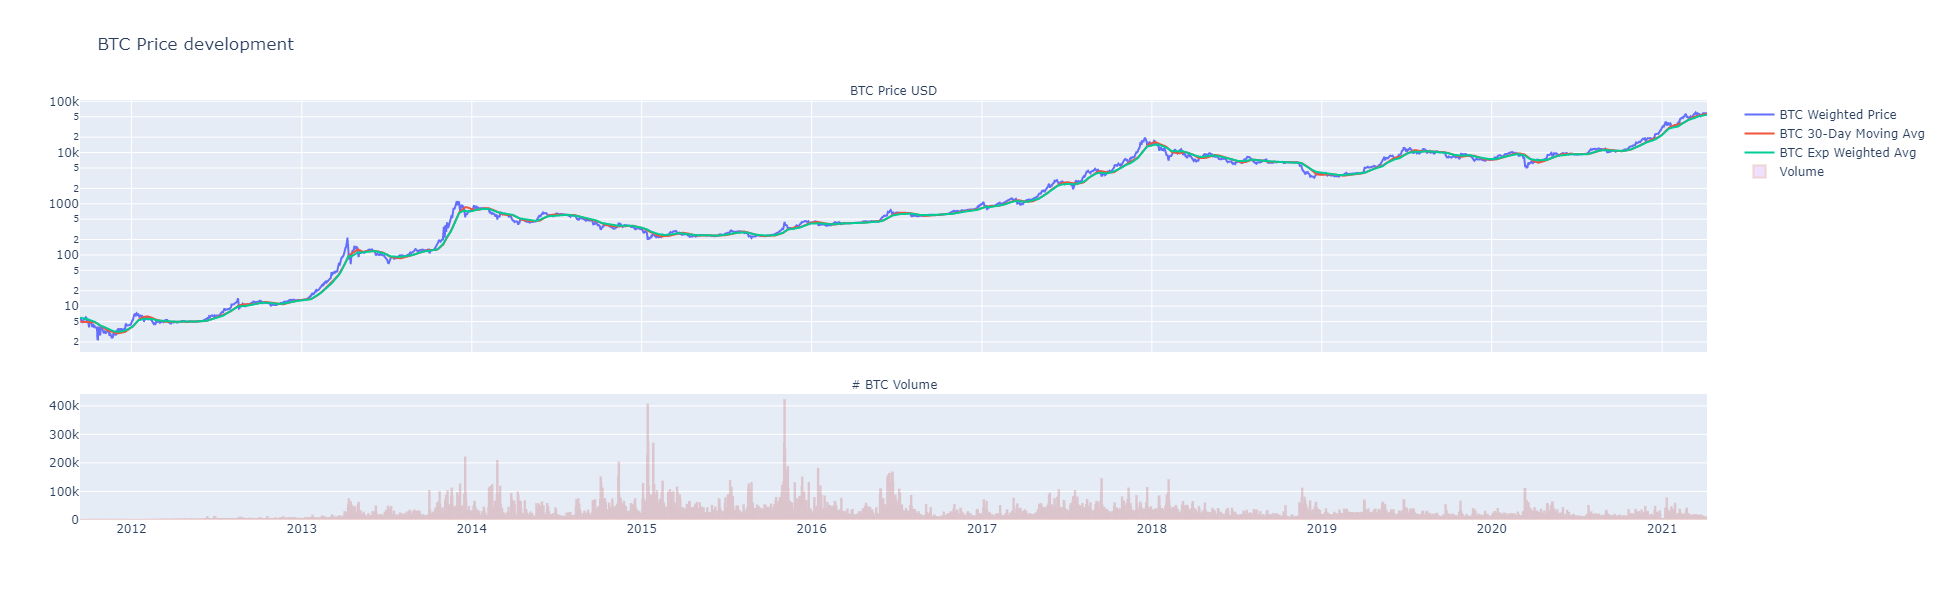

In [96]:
fig = go.Figure()

date = btc_data_prepared.index
price = btc_data_prepared['WeightedPrice_filled']
volume = btc_data_prepared['Volume_filled']
ma = btc_data_prepared['SMA_30']
ema = btc_data_prepared['EMA']


fig = make_subplots(rows=2, cols=1, shared_xaxes=True,
                   vertical_spacing=0.1, subplot_titles=('BTC Price USD', '# BTC Volume'),
                   row_width=[0.5, 1])

fig.add_trace(go.Scatter(x=date, y=price,
                    mode='lines',
                    name='BTC Weighted Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=date, y=ma,
                    mode='lines',
                    name='BTC 30-Day Moving Avg'), row=1, col=1)

fig.add_trace(go.Scatter(x=date, y=ema,
                    mode='lines',
                    name='BTC Exp Weighted Avg'), row=1, col=1)

fig.add_trace(go.Bar(x=date, y=volume,
                     name='Volume',
                     opacity=0.2,
                     marker=dict(
                         line=dict(color='firebrick', width=2)
                     )), row=2, col=1)

fig.update_annotations(font_size=12)

title = "BTC Price development"
                              
fig.update_layout(title=title,
                  dragmode='select',
                  width=1000,
                  height=600,
                  hovermode='closest',
                  yaxis_type='log'
                 )


fig.show()

In [97]:
btc_data_prepared.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3495 entries, 2011-09-13 to 2021-04-07
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   WeightedPrice_filled  3495 non-null   float64
 1   Volume_filled         3495 non-null   float64
 2   SMA_30                3495 non-null   float64
 3   EMA                   3495 non-null   float64
dtypes: float64(4)
memory usage: 136.5 KB


In [98]:
btc_data_prepared

WeightedPrice_filled  Volume_filled        SMA_30           EMA
Date                                                                       
2011-09-13              5.929231      58.371382      4.970674      5.929231
2011-09-14              5.590798      61.145984      4.970674      5.912722
2011-09-15              5.094272      80.140795      4.970674      5.872797
2011-09-16              4.854515      39.914007      4.970674      5.823125
2011-09-17              4.870000       0.300000      4.970674      5.776631
...                          ...            ...           ...           ...
2021-04-03          58565.891748    5306.100267  55802.249032  53819.651323
2021-04-04          57566.981078    3696.706894  56131.256293  54002.447896
2021-04-05          58318.050615    5907.412484  56463.673440  54212.965102
2021-04-06          58337.487728    5483.860141  56729.149363  54414.161328
2021-04-07          56729.622038   10437.369756  56924.711486  54527.110631

[3495 rows x 4 columns]

In [99]:
df_altcoin_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37365 entries, 0 to 37364
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           37365 non-null  datetime64[ns]
 1   Open           37365 non-null  float64       
 2   High           37365 non-null  float64       
 3   Low            37365 non-null  float64       
 4   Close          37365 non-null  float64       
 5   Volume_BTC     37365 non-null  float64       
 6   Volume_Market  37365 non-null  float64       
 7   WeightedPrice  37365 non-null  float64       
 8   ExchangeID     37365 non-null  int64         
 9   MarketID       37365 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2)
memory usage: 2.9 MB


In [100]:
df_fin_asset_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56445 entries, 0 to 56444
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        56445 non-null  object 
 1   Open        56445 non-null  float64
 2   High        56445 non-null  float64
 3   Low         56445 non-null  float64
 4   Close       56445 non-null  float64
 5   AdjClose    56445 non-null  float64
 6   Volume      56445 non-null  int64  
 7   Asset       56445 non-null  object 
 8   Symbol      56445 non-null  object 
 9   Source      56445 non-null  object 
 10  ExchangeID  56445 non-null  int64  
 11  MarketID    56445 non-null  int64  
dtypes: float64(5), int64(3), object(4)
memory usage: 5.2+ MB


In [101]:
altcoin_data_prepared = df_altcoin_prep.merge(df_markets_prep[['Symbol', 'MarketID']], how='left', 
                                      left_on='MarketID', right_on='MarketID').drop(columns=['MarketID'])
altcoin_data_prepared['Symbol'] = altcoin_data_prepared['Symbol'].str.upper()
altcoin_data_prepared['Month'] = altcoin_data_prepared['Date'].dt.month_name()
altcoin_data_prepared['Year'] = altcoin_data_prepared['Date'].dt.year
altcoin_data_prepared_copy = altcoin_data_prepared.copy()
altcoin_data_prepared = altcoin_data_prepared[['Date', 'WeightedPrice', 'Symbol', 'Year', 'Month']]
altcoin_data_prepared.tail()

Date  WeightedPrice Symbol  Year  Month
37360 2021-03-31   1.257700e-04    BNT  2021  March
37361 2021-03-31   4.200000e-07     SC  2021  March
37362 2021-03-31   4.327120e-03    XMR  2021  March
37363 2021-03-31   3.042170e-03    DCR  2021  March
37364 2021-03-31   1.009900e-04    LSK  2021  March

In [102]:
altcoin_data_prepared.isna().sum()

Date             0
WeightedPrice    0
Symbol           0
Year             0
Month            0
dtype: int64

In [103]:
altcoin_data_prepared.loc[(altcoin_data_prepared==0).any(axis=1)]

Empty DataFrame
Columns: [Date, WeightedPrice, Symbol, Year, Month]
Index: []

In [104]:
altcoin_data_prepared[altcoin_data_prepared['Symbol']=='ETH']

Date  WeightedPrice Symbol  Year   Month
2618  2015-08-08       0.004530    ETH  2015  August
2623  2015-08-09       0.002860    ETH  2015  August
2631  2015-08-10       0.002524    ETH  2015  August
2638  2015-08-11       0.003286    ETH  2015  August
2646  2015-08-12       0.004196    ETH  2015  August
...          ...            ...    ...   ...     ...
37208 2021-03-27       0.030777    ETH  2021   March
37248 2021-03-28       0.030491    ETH  2021   March
37299 2021-03-29       0.030855    ETH  2021   March
37326 2021-03-30       0.031326    ETH  2021   March
37339 2021-03-31       0.031611    ETH  2021   March

[2063 rows x 5 columns]

In [105]:
altcoin_data_grouped = altcoin_data_prepared.groupby(['Date'], as_index=False).agg({'WeightedPrice':'mean'})

In [106]:
altcoin_data_grouped.set_index('Date', inplace=True)

In [107]:
altcoin_data_grouped = altcoin_data_grouped.merge(btc_data_prepared['WeightedPrice_filled'], how='left',
                                                   left_index=True, right_index=True)

In [108]:
altcoin_data_grouped['WeightedPrice_USD'] = altcoin_data_grouped['WeightedPrice'] * altcoin_data_grouped['WeightedPrice_filled']

In [109]:
altcoin_data_grouped

WeightedPrice  WeightedPrice_filled  WeightedPrice_USD
Date                                                              
2014-01-18       0.028039            811.719082          22.759824
2014-01-19       0.028300            823.019663          23.291456
2014-01-20       0.028300            831.905064          23.542913
2014-01-21       0.014151            824.335995          11.665278
2014-01-22       0.014151            818.098875          11.577040
...                   ...                   ...                ...
2021-03-27       0.034416          55289.929900        1902.859143
2021-03-28       0.034456          55718.893686        1919.829411
2021-03-29       0.034437          57221.709565        1970.546891
2021-03-30       0.034425          58468.408195        2012.799344
2021-03-31       0.034449          58599.034605        2018.706454

[2634 rows x 3 columns]

In [110]:
altcoin_data_grouped.drop(columns=['WeightedPrice', 'WeightedPrice_filled'], inplace=True)

In [111]:
# Exponential Moving Average

altcoin_data_grouped['Altcoin_EMA'] = altcoin_data_grouped.loc[:,'WeightedPrice_USD'].ewm(span=40, adjust=False).mean()

In [112]:
altcoin_data_grouped

WeightedPrice_USD  Altcoin_EMA
Date                                      
2014-01-18          22.759824    22.759824
2014-01-19          23.291456    22.785757
2014-01-20          23.542913    22.822692
2014-01-21          11.665278    22.278427
2014-01-22          11.577040    21.756409
...                       ...          ...
2021-03-27        1902.859143  1866.321914
2021-03-28        1919.829411  1868.932036
2021-03-29        1970.546891  1873.888858
2021-03-30        2012.799344  1880.664979
2021-03-31        2018.706454  1887.398710

[2634 rows x 2 columns]

In [113]:
btc_altcoin_merged = btc_data_prepared.merge(altcoin_data_grouped['Altcoin_EMA'], how='left', left_index=True, right_index=True)

In [114]:
btc_altcoin_merged.isna().sum()

WeightedPrice_filled      0
Volume_filled             0
SMA_30                    0
EMA                       0
Altcoin_EMA             865
dtype: int64

In [115]:
btc_altcoin_merged[btc_altcoin_merged['Altcoin_EMA'].isna()]

WeightedPrice_filled  Volume_filled        SMA_30           EMA  \
Date                                                                          
2011-09-13              5.929231      58.371382      4.970674      5.929231   
2011-09-14              5.590798      61.145984      4.970674      5.912722   
2011-09-15              5.094272      80.140795      4.970674      5.872797   
2011-09-16              4.854515      39.914007      4.970674      5.823125   
2011-09-17              4.870000       0.300000      4.970674      5.776631   
...                          ...            ...           ...           ...   
2021-04-03          58565.891748    5306.100267  55802.249032  53819.651323   
2021-04-04          57566.981078    3696.706894  56131.256293  54002.447896   
2021-04-05          58318.050615    5907.412484  56463.673440  54212.965102   
2021-04-06          58337.487728    5483.860141  56729.149363  54414.161328   
2021-04-07          56729.622038   10437.369756  56924.711486  54527.110631   

            Altcoin_EMA  
Date                     
2011-09-13          NaN  
2011-09-14          NaN  
2011-09-15          NaN  
2011-09-16          NaN  
2011-09-17          NaN  
...                 ...  
2021-04-03          NaN  
2021-04-04          NaN  
2021-04-05          NaN  
2021-04-06          NaN  
2021-04-07          NaN  

[865 rows x 5 columns]

In [116]:
btc_altcoin_merged['Altcoin_EMA_filled'] = btc_altcoin_merged['Altcoin_EMA'].fillna(
    value=btc_altcoin_merged['Altcoin_EMA'].rolling(window=30, center=True, min_periods=2).mean())

In [117]:
btc_altcoin_merged.isna().sum()

WeightedPrice_filled      0
Volume_filled             0
SMA_30                    0
EMA                       0
Altcoin_EMA             865
Altcoin_EMA_filled      845
dtype: int64

In [118]:
btc_altcoin_merged.head(850)

WeightedPrice_filled  Volume_filled      SMA_30         EMA  \
Date                                                                      
2011-09-13              5.929231      58.371382    4.970674    5.929231   
2011-09-14              5.590798      61.145984    4.970674    5.912722   
2011-09-15              5.094272      80.140795    4.970674    5.872797   
2011-09-16              4.854515      39.914007    4.970674    5.823125   
2011-09-17              4.870000       0.300000    4.970674    5.776631   
...                          ...            ...         ...         ...   
2014-01-05            875.455969   45162.832295  750.762993  728.931939   
2014-01-06            936.596268   51376.529373  758.079654  739.061906   
2014-01-07            859.785532   63925.712454  762.664528  744.950863   
2014-01-08            821.643821   45099.601243  760.751355  748.691983   
2014-01-09            819.404772   42003.092179  756.121957  752.141387   

            Altcoin_EMA  Altcoin_EMA_filled  
Date                                         
2011-09-13          NaN                 NaN  
2011-09-14          NaN                 NaN  
2011-09-15          NaN                 NaN  
2011-09-16          NaN                 NaN  
2011-09-17          NaN                 NaN  
...                 ...                 ...  
2014-01-05          NaN           22.772790  
2014-01-06          NaN           22.789424  
2014-01-07          NaN           22.661675  
2014-01-08          NaN           22.480622  
2014-01-09          NaN           22.277016  

[850 rows x 6 columns]

In [119]:
btc_altcoin_prepared = btc_altcoin_merged[btc_altcoin_merged.index>='2014-01-05']

In [120]:
btc_altcoin_prepared.drop('Altcoin_EMA', axis=1, inplace=True)

In [121]:
btc_altcoin_prepared.rename(columns={'WeightedPrice_filled': 'WeightedPrice', 'Volume_filled': 'Volume', 
                                     'EMA': 'EMA_40', 'Altcoin_EMA_filled': 'Altcoin_EMA_40'}, inplace=True)

In [122]:
btc_altcoin_prepared.isna().sum()

WeightedPrice     0
Volume            0
SMA_30            0
EMA_40            0
Altcoin_EMA_40    0
dtype: int64

In [123]:
btc_altcoin_prepared

WeightedPrice        Volume        SMA_30        EMA_40  \
Date                                                                  
2014-01-05     875.455969  45162.832295    750.762993    728.931939   
2014-01-06     936.596268  51376.529373    758.079654    739.061906   
2014-01-07     859.785532  63925.712454    762.664528    744.950863   
2014-01-08     821.643821  45099.601243    760.751355    748.691983   
2014-01-09     819.404772  42003.092179    756.121957    752.141387   
...                   ...           ...           ...           ...   
2021-04-03   58565.891748   5306.100267  55802.249032  53819.651323   
2021-04-04   57566.981078   3696.706894  56131.256293  54002.447896   
2021-04-05   58318.050615   5907.412484  56463.673440  54212.965102   
2021-04-06   58337.487728   5483.860141  56729.149363  54414.161328   
2021-04-07   56729.622038  10437.369756  56924.711486  54527.110631   

            Altcoin_EMA_40  
Date                        
2014-01-05       22.772790  
2014-01-06       22.789424  
2014-01-07       22.661675  
2014-01-08       22.480622  
2014-01-09       22.277016  
...                    ...  
2021-04-03     1846.969313  
2021-04-04     1854.749106  
2021-04-05     1862.796041  
2021-04-06     1871.520143  
2021-04-07     1871.856677  

[2650 rows x 5 columns]

In [124]:
altcoin_data_prepared.tail()

Date  WeightedPrice Symbol  Year  Month
37360 2021-03-31   1.257700e-04    BNT  2021  March
37361 2021-03-31   4.200000e-07     SC  2021  March
37362 2021-03-31   4.327120e-03    XMR  2021  March
37363 2021-03-31   3.042170e-03    DCR  2021  March
37364 2021-03-31   1.009900e-04    LSK  2021  March

In [125]:
altcoin_data_prepared.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37365 entries, 0 to 37364
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           37365 non-null  datetime64[ns]
 1   WeightedPrice  37365 non-null  float64       
 2   Symbol         37365 non-null  object        
 3   Year           37365 non-null  int64         
 4   Month          37365 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 1.7+ MB


In [126]:
altcoin_data_prepared.loc[(altcoin_data_prepared==0).any(axis=1)].count()

Date             0
WeightedPrice    0
Symbol           0
Year             0
Month            0
dtype: int64

In [127]:
altcoin_data_prepared_copy.tail()

Date          Open          High           Low         Close  \
37360 2021-03-31  1.255000e-04  1.261500e-04  1.242100e-04  1.261500e-04   
37361 2021-03-31  4.300000e-07  4.500000e-07  4.000000e-07  4.400000e-07   
37362 2021-03-31  4.161090e-03  4.508000e-03  4.133010e-03  4.191210e-03   
37363 2021-03-31  3.065820e-03  3.076980e-03  3.023070e-03  3.041090e-03   
37364 2021-03-31  1.011000e-04  1.060200e-04  9.683000e-05  1.060200e-04   

       Volume_BTC  Volume_Market  WeightedPrice  ExchangeID Symbol  Month  \
37360    0.014222   1.130724e+02   1.257700e-04          87    BNT  March   
37361    7.483935   1.753603e+07   4.200000e-07          87     SC  March   
37362   29.322857   6.776518e+03   4.327120e-03          87    XMR  March   
37363    0.792017   2.603453e+02   3.042170e-03          87    DCR  March   
37364    1.016691   1.006703e+04   1.009900e-04          87    LSK  March   

       Year  
37360  2021  
37361  2021  
37362  2021  
37363  2021  
37364  2021

In [128]:
altcoin_data_prepared_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37365 entries, 0 to 37364
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           37365 non-null  datetime64[ns]
 1   Open           37365 non-null  float64       
 2   High           37365 non-null  float64       
 3   Low            37365 non-null  float64       
 4   Close          37365 non-null  float64       
 5   Volume_BTC     37365 non-null  float64       
 6   Volume_Market  37365 non-null  float64       
 7   WeightedPrice  37365 non-null  float64       
 8   ExchangeID     37365 non-null  int64         
 9   Symbol         37365 non-null  object        
 10  Month          37365 non-null  object        
 11  Year           37365 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 3.7+ MB


In [129]:
altcoin_for_top10 = altcoin_data_prepared.merge(altcoin_data_prepared_copy[['Date', 'Symbol', 'Volume_BTC']], left_on=['Date', 'Symbol'], right_on=['Date', 'Symbol'])

In [130]:
altcoin_for_top10

Date  WeightedPrice Symbol  Year    Month  Volume_BTC
0     2014-01-18   2.803904e-02    LTC  2014  January    0.023696
1     2014-01-19   2.830000e-02    LTC  2014  January    0.000311
2     2014-01-20   2.830000e-02    LTC  2014  January    0.000000
3     2014-01-21   2.240000e-06   DOGE  2014  January    0.013465
4     2014-01-21   2.830000e-02    LTC  2014  January    0.000000
...          ...            ...    ...   ...      ...         ...
37360 2021-03-31   1.257700e-04    BNT  2021    March    0.014222
37361 2021-03-31   4.200000e-07     SC  2021    March    7.483935
37362 2021-03-31   4.327120e-03    XMR  2021    March   29.322857
37363 2021-03-31   3.042170e-03    DCR  2021    March    0.792017
37364 2021-03-31   1.009900e-04    LSK  2021    March    1.016691

[37365 rows x 6 columns]

In [131]:
top10_altcoin = pd.DataFrame(altcoin_for_top10.groupby('Symbol')['Volume_BTC'].sum().nlargest(10))

In [132]:
top10 = top10_altcoin.reset_index()['Symbol']

In [133]:
top10

0     ETH
1     XRP
2     LTC
3     XMR
4     ETC
5    DASH
6     XEM
7      SC
8     ZEC
9     LSK
Name: Symbol, dtype: object

In [134]:
altcoin_data_to_merge = altcoin_data_prepared.loc[altcoin_data_prepared['Symbol'].isin(top10)]

In [135]:
altcoin_data_to_merge.set_index('Date', inplace=True)

In [136]:
altcoin_data_to_merge

WeightedPrice Symbol  Year    Month
Date                                           
2014-01-18   2.803904e-02    LTC  2014  January
2014-01-19   2.830000e-02    LTC  2014  January
2014-01-20   2.830000e-02    LTC  2014  January
2014-01-21   2.830000e-02    LTC  2014  January
2014-01-22   2.830000e-02    LTC  2014  January
...                   ...    ...   ...      ...
2021-03-31   9.400000e-06    XRP  2021    March
2021-03-31   3.308140e-03    LTC  2021    March
2021-03-31   4.200000e-07     SC  2021    March
2021-03-31   4.327120e-03    XMR  2021    March
2021-03-31   1.009900e-04    LSK  2021    March

[21574 rows x 4 columns]

In [137]:
altcoin_data_to_merge = altcoin_data_to_merge.merge(btc_data_prepared['WeightedPrice_filled'], how='left', left_index=True, right_index=True)

In [138]:
altcoin_data_to_merge

WeightedPrice Symbol  Year    Month  WeightedPrice_filled
Date                                                                 
2014-01-18   2.803904e-02    LTC  2014  January            811.719082
2014-01-19   2.830000e-02    LTC  2014  January            823.019663
2014-01-20   2.830000e-02    LTC  2014  January            831.905064
2014-01-21   2.830000e-02    LTC  2014  January            824.335995
2014-01-22   2.830000e-02    LTC  2014  January            818.098875
...                   ...    ...   ...      ...                   ...
2021-03-31   9.400000e-06    XRP  2021    March          58599.034605
2021-03-31   3.308140e-03    LTC  2021    March          58599.034605
2021-03-31   4.200000e-07     SC  2021    March          58599.034605
2021-03-31   4.327120e-03    XMR  2021    March          58599.034605
2021-03-31   1.009900e-04    LSK  2021    March          58599.034605

[21574 rows x 5 columns]

In [139]:
altcoin_data_to_merge['WeightedPrice_USD'] = altcoin_data_to_merge['WeightedPrice'] * altcoin_data_to_merge['WeightedPrice_filled']

In [140]:
altcoin_data_to_pivot = altcoin_data_to_merge[['WeightedPrice_USD', 'Symbol']]

In [141]:
altcoin_data_to_pivot

WeightedPrice_USD Symbol
Date                                
2014-01-18          22.759824    LTC
2014-01-19          23.291456    LTC
2014-01-20          23.542913    LTC
2014-01-21          23.328709    LTC
2014-01-22          23.152198    LTC
...                       ...    ...
2021-03-31           0.550831    XRP
2021-03-31         193.853810    LTC
2021-03-31           0.024612     SC
2021-03-31         253.565055    XMR
2021-03-31           5.917917    LSK

[21574 rows x 2 columns]

In [142]:
altcoin_data_to_pivot.isna().sum()

WeightedPrice_USD    0
Symbol               0
dtype: int64

In [143]:
altcoin_data_pivoted = altcoin_data_to_pivot.pivot_table('WeightedPrice_USD', ['Date'], 'Symbol')

In [144]:
altcoin_data_pivoted

Symbol            DASH        ETC          ETH       LSK         LTC  \
Date                                                                   
2014-01-18         NaN        NaN          NaN       NaN   22.759824   
2014-01-19         NaN        NaN          NaN       NaN   23.291456   
2014-01-20         NaN        NaN          NaN       NaN   23.542913   
2014-01-21         NaN        NaN          NaN       NaN   23.328709   
2014-01-22         NaN        NaN          NaN       NaN   23.152198   
...                ...        ...          ...       ...         ...   
2021-03-27  198.875113  11.665069  1701.659278  4.320908  182.863150   
2021-03-28  201.448317  11.674780  1698.945961  5.199130  183.556980   
2021-03-29  211.618471  12.036587  1765.566121  5.058971  194.511468   
2021-03-30  215.048559  12.601696  1831.593049  5.657988  195.245310   
2021-03-31  215.132878  12.959762  1852.379357  5.917917  193.853810   

Symbol            SC       XEM         XMR       XRP         ZEC  
Date                                                              
2014-01-18       NaN       NaN         NaN       NaN         NaN  
2014-01-19       NaN       NaN         NaN       NaN         NaN  
2014-01-20       NaN       NaN         NaN       NaN         NaN  
2014-01-21       NaN       NaN         NaN       NaN         NaN  
2014-01-22       NaN       NaN         NaN       NaN         NaN  
...              ...       ...         ...       ...         ...  
2021-03-27  0.022116  0.341139  220.338664  0.555664  131.456232  
2021-03-28  0.025074  0.353815  228.466409  0.547717  136.299558  
2021-03-29  0.024605  0.365075  236.856678  0.562489  150.032461  
2021-03-30  0.025141  0.386476  240.329714  0.572406  151.004019  
2021-03-31  0.024612  0.363314  253.565055  0.550831  153.029621  

[2630 rows x 10 columns]

In [145]:
altcoin_data_pivoted['Year'] = altcoin_data_pivoted.index.year
altcoin_data_pivoted['Month'] = altcoin_data_pivoted.index.month_name()
altcoin_data_pivoted

Symbol            DASH        ETC          ETH       LSK         LTC  \
Date                                                                   
2014-01-18         NaN        NaN          NaN       NaN   22.759824   
2014-01-19         NaN        NaN          NaN       NaN   23.291456   
2014-01-20         NaN        NaN          NaN       NaN   23.542913   
2014-01-21         NaN        NaN          NaN       NaN   23.328709   
2014-01-22         NaN        NaN          NaN       NaN   23.152198   
...                ...        ...          ...       ...         ...   
2021-03-27  198.875113  11.665069  1701.659278  4.320908  182.863150   
2021-03-28  201.448317  11.674780  1698.945961  5.199130  183.556980   
2021-03-29  211.618471  12.036587  1765.566121  5.058971  194.511468   
2021-03-30  215.048559  12.601696  1831.593049  5.657988  195.245310   
2021-03-31  215.132878  12.959762  1852.379357  5.917917  193.853810   

Symbol            SC       XEM         XMR       XRP         ZEC  Year  \
Date                                                                     
2014-01-18       NaN       NaN         NaN       NaN         NaN  2014   
2014-01-19       NaN       NaN         NaN       NaN         NaN  2014   
2014-01-20       NaN       NaN         NaN       NaN         NaN  2014   
2014-01-21       NaN       NaN         NaN       NaN         NaN  2014   
2014-01-22       NaN       NaN         NaN       NaN         NaN  2014   
...              ...       ...         ...       ...         ...   ...   
2021-03-27  0.022116  0.341139  220.338664  0.555664  131.456232  2021   
2021-03-28  0.025074  0.353815  228.466409  0.547717  136.299558  2021   
2021-03-29  0.024605  0.365075  236.856678  0.562489  150.032461  2021   
2021-03-30  0.025141  0.386476  240.329714  0.572406  151.004019  2021   
2021-03-31  0.024612  0.363314  253.565055  0.550831  153.029621  2021   

Symbol        Month  
Date                 
2014-01-18  January  
2014-01-19  January  
2014-01-20  January  
2014-01-21  January  
2014-01-22  January  
...             ...  
2021-03-27    March  
2021-03-28    March  
2021-03-29    March  
2021-03-30    March  
2021-03-31    March  

[2630 rows x 12 columns]

In [146]:
altcoin_data_pivoted.isna().sum()

Symbol
DASH       20
ETC       918
ETH       567
LSK       857
LTC         0
SC        584
XEM       437
XMR       121
XRP       208
ZEC      1014
Year        0
Month       0
dtype: int64

In [147]:
for col in altcoin_data_pivoted.columns[:10]:
    print(str(col))

DASH
ETC
ETH
LSK
LTC
SC
XEM
XMR
XRP
ZEC


In [148]:
altcoin_data_pivoted.groupby(['Year', 'Month'])['DASH'].mean()

Year  Month    
2014  April          0.855532
      August         3.993531
      December       2.107717
      February       0.588973
      January             NaN
                      ...    
2020  October       69.327944
      September     72.495316
2021  February     198.385532
      January      109.285013
      March        217.880655
Name: DASH, Length: 87, dtype: float64

In [149]:
altcoin_data_pivoted.iloc[0]['DASH']

nan

In [150]:
list(set(altcoin_data_pivoted['Year']))

[2016, 2017, 2018, 2019, 2020, 2021, 2014, 2015]

In [151]:
# Fill the NaN with the mean price per year & month

years = list(set(altcoin_data_pivoted['Year']))
months = list(set(altcoin_data_pivoted['Month']))

for year in years:
    for month in months:
        for col in altcoin_data_pivoted.columns[:10]:
            altcoin_data_pivoted[col].fillna(altcoin_data_pivoted[col][(altcoin_data_pivoted['Year']==year) & (altcoin_data_pivoted['Month']==month)].mean(), inplace=True)

In [152]:
altcoin_data_pivoted

Symbol            DASH        ETC          ETH       LSK         LTC  \
Date                                                                   
2014-01-18    9.164219   0.880206    10.015527  0.176576   22.759824   
2014-01-19    9.164219   0.880206    10.015527  0.176576   23.291456   
2014-01-20    9.164219   0.880206    10.015527  0.176576   23.542913   
2014-01-21    9.164219   0.880206    10.015527  0.176576   23.328709   
2014-01-22    9.164219   0.880206    10.015527  0.176576   23.152198   
...                ...        ...          ...       ...         ...   
2021-03-27  198.875113  11.665069  1701.659278  4.320908  182.863150   
2021-03-28  201.448317  11.674780  1698.945961  5.199130  183.556980   
2021-03-29  211.618471  12.036587  1765.566121  5.058971  194.511468   
2021-03-30  215.048559  12.601696  1831.593049  5.657988  195.245310   
2021-03-31  215.132878  12.959762  1852.379357  5.917917  193.853810   

Symbol            SC       XEM         XMR       XRP         ZEC  Year  \
Date                                                                     
2014-01-18  0.000301  0.003948    6.682221  0.007648  276.131749  2014   
2014-01-19  0.000301  0.003948    6.682221  0.007648  276.131749  2014   
2014-01-20  0.000301  0.003948    6.682221  0.007648  276.131749  2014   
2014-01-21  0.000301  0.003948    6.682221  0.007648  276.131749  2014   
2014-01-22  0.000301  0.003948    6.682221  0.007648  276.131749  2014   
...              ...       ...         ...       ...         ...   ...   
2021-03-27  0.022116  0.341139  220.338664  0.555664  131.456232  2021   
2021-03-28  0.025074  0.353815  228.466409  0.547717  136.299558  2021   
2021-03-29  0.024605  0.365075  236.856678  0.562489  150.032461  2021   
2021-03-30  0.025141  0.386476  240.329714  0.572406  151.004019  2021   
2021-03-31  0.024612  0.363314  253.565055  0.550831  153.029621  2021   

Symbol        Month  
Date                 
2014-01-18  January  
2014-01-19  January  
2014-01-20  January  
2014-01-21  January  
2014-01-22  January  
...             ...  
2021-03-27    March  
2021-03-28    March  
2021-03-29    March  
2021-03-30    March  
2021-03-31    March  

[2630 rows x 12 columns]

In [153]:
altcoin_data_pivoted.isna().sum()

Symbol
DASH     0
ETC      0
ETH      0
LSK      0
LTC      0
SC       0
XEM      0
XMR      0
XRP      0
ZEC      0
Year     0
Month    0
dtype: int64

In [154]:
btc_dataset_merged = btc_altcoin_prepared.merge(altcoin_data_pivoted, how='left', left_index=True, right_index=True)

In [155]:
btc_altcoin_dataset_final = btc_dataset_merged.drop(['Year', 'Month'], axis=1)
btc_altcoin_dataset_final['Day_of_Week'] = btc_altcoin_dataset_final.index.day_name()

In [156]:
btc_altcoin_dataset_final

WeightedPrice        Volume        SMA_30        EMA_40  \
Date                                                                  
2014-01-05     875.455969  45162.832295    750.762993    728.931939   
2014-01-06     936.596268  51376.529373    758.079654    739.061906   
2014-01-07     859.785532  63925.712454    762.664528    744.950863   
2014-01-08     821.643821  45099.601243    760.751355    748.691983   
2014-01-09     819.404772  42003.092179    756.121957    752.141387   
...                   ...           ...           ...           ...   
2021-04-03   58565.891748   5306.100267  55802.249032  53819.651323   
2021-04-04   57566.981078   3696.706894  56131.256293  54002.447896   
2021-04-05   58318.050615   5907.412484  56463.673440  54212.965102   
2021-04-06   58337.487728   5483.860141  56729.149363  54414.161328   
2021-04-07   56729.622038  10437.369756  56924.711486  54527.110631   

            Altcoin_EMA_40  DASH  ETC  ETH  LSK  LTC  SC  XEM  XMR  XRP  ZEC  \
Date                                                                           
2014-01-05       22.772790   NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN   
2014-01-06       22.789424   NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN   
2014-01-07       22.661675   NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN   
2014-01-08       22.480622   NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN   
2014-01-09       22.277016   NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN   
...                    ...   ...  ...  ...  ...  ...  ..  ...  ...  ...  ...   
2021-04-03     1846.969313   NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN   
2021-04-04     1854.749106   NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN   
2021-04-05     1862.796041   NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN   
2021-04-06     1871.520143   NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN   
2021-04-07     1871.856677   NaN  NaN  NaN  NaN  NaN NaN  NaN  NaN  NaN  NaN   

           Day_of_Week  
Date                    
2014-01-05      Sunday  
2014-01-06      Monday  
2014-01-07     Tuesday  
2014-01-08   Wednesday  
2014-01-09    Thursday  
...                ...  
2021-04-03    Saturday  
2021-04-04      Sunday  
2021-04-05      Monday  
2021-04-06     Tuesday  
2021-04-07   Wednesday  

[2650 rows x 16 columns]

In [157]:
btc_altcoin_dataset_final.isna().sum()

WeightedPrice      0
Volume             0
SMA_30             0
EMA_40             0
Altcoin_EMA_40     0
DASH              20
ETC               20
ETH               20
LSK               20
LTC               20
SC                20
XEM               20
XMR               20
XRP               20
ZEC               20
Day_of_Week        0
dtype: int64

In [158]:
btc_altcoin_dataset_final.loc[(btc_altcoin_dataset_final==0).any(axis=1)]

Empty DataFrame
Columns: [WeightedPrice, Volume, SMA_30, EMA_40, Altcoin_EMA_40, DASH, ETC, ETH, LSK, LTC, SC, XEM, XMR, XRP, ZEC, Day_of_Week]
Index: []

In [159]:
btc_altcoin_dataset_cleansed = btc_altcoin_dataset_final.dropna()

In [160]:
btc_altcoin_dataset_cleansed.isna().sum()

WeightedPrice     0
Volume            0
SMA_30            0
EMA_40            0
Altcoin_EMA_40    0
DASH              0
ETC               0
ETH               0
LSK               0
LTC               0
SC                0
XEM               0
XMR               0
XRP               0
ZEC               0
Day_of_Week       0
dtype: int64

In [161]:
btc_altcoin_dataset_cleansed.tail()

WeightedPrice        Volume        SMA_30        EMA_40  \
Date                                                                  
2021-03-27   55289.929900   7217.464370  53393.593453  51985.967239   
2021-03-28   55718.893686   6154.045376  53704.209208  52168.061212   
2021-03-29   57221.709565  12191.904750  54046.677870  52414.580644   
2021-03-30   58468.408195   7931.877347  54508.825234  52709.889305   
2021-03-31   58599.034605  11302.809444  54866.405334  52997.164685   

            Altcoin_EMA_40        DASH        ETC          ETH       LSK  \
Date                                                                       
2021-03-27     1866.321914  198.875113  11.665069  1701.659278  4.320908   
2021-03-28     1868.932036  201.448317  11.674780  1698.945961  5.199130   
2021-03-29     1873.888858  211.618471  12.036587  1765.566121  5.058971   
2021-03-30     1880.664979  215.048559  12.601696  1831.593049  5.657988   
2021-03-31     1887.398710  215.132878  12.959762  1852.379357  5.917917   

                   LTC        SC       XEM         XMR       XRP         ZEC  \
Date                                                                           
2021-03-27  182.863150  0.022116  0.341139  220.338664  0.555664  131.456232   
2021-03-28  183.556980  0.025074  0.353815  228.466409  0.547717  136.299558   
2021-03-29  194.511468  0.024605  0.365075  236.856678  0.562489  150.032461   
2021-03-30  195.245310  0.025141  0.386476  240.329714  0.572406  151.004019   
2021-03-31  193.853810  0.024612  0.363314  253.565055  0.550831  153.029621   

           Day_of_Week  
Date                    
2021-03-27    Saturday  
2021-03-28      Sunday  
2021-03-29      Monday  
2021-03-30     Tuesday  
2021-03-31   Wednesday

In [162]:
btc_altcoin_dataset_cleansed.to_csv('btc_altcoin_dataset_cleansed.csv')

In [163]:
df_check = pd.read_csv('btc_altcoin_dataset_cleansed.csv')
df_check.tail()

Date  WeightedPrice        Volume        SMA_30        EMA_40  \
2625  2021-03-27   55289.929900   7217.464370  53393.593453  51985.967239   
2626  2021-03-28   55718.893686   6154.045376  53704.209208  52168.061212   
2627  2021-03-29   57221.709565  12191.904750  54046.677870  52414.580644   
2628  2021-03-30   58468.408195   7931.877347  54508.825234  52709.889305   
2629  2021-03-31   58599.034605  11302.809444  54866.405334  52997.164685   

      Altcoin_EMA_40        DASH        ETC          ETH       LSK  \
2625     1866.321914  198.875113  11.665069  1701.659278  4.320908   
2626     1868.932036  201.448317  11.674780  1698.945961  5.199130   
2627     1873.888858  211.618471  12.036587  1765.566121  5.058971   
2628     1880.664979  215.048559  12.601696  1831.593049  5.657988   
2629     1887.398710  215.132878  12.959762  1852.379357  5.917917   

             LTC        SC       XEM         XMR       XRP         ZEC  \
2625  182.863150  0.022116  0.341139  220.338664  0.555664  131.456232   
2626  183.556980  0.025074  0.353815  228.466409  0.547717  136.299558   
2627  194.511468  0.024605  0.365075  236.856678  0.562489  150.032461   
2628  195.245310  0.025141  0.386476  240.329714  0.572406  151.004019   
2629  193.853810  0.024612  0.363314  253.565055  0.550831  153.029621   

     Day_of_Week  
2625    Saturday  
2626      Sunday  
2627      Monday  
2628     Tuesday  
2629   Wednesday

## EDA on the prepared dataset

### Pairplots

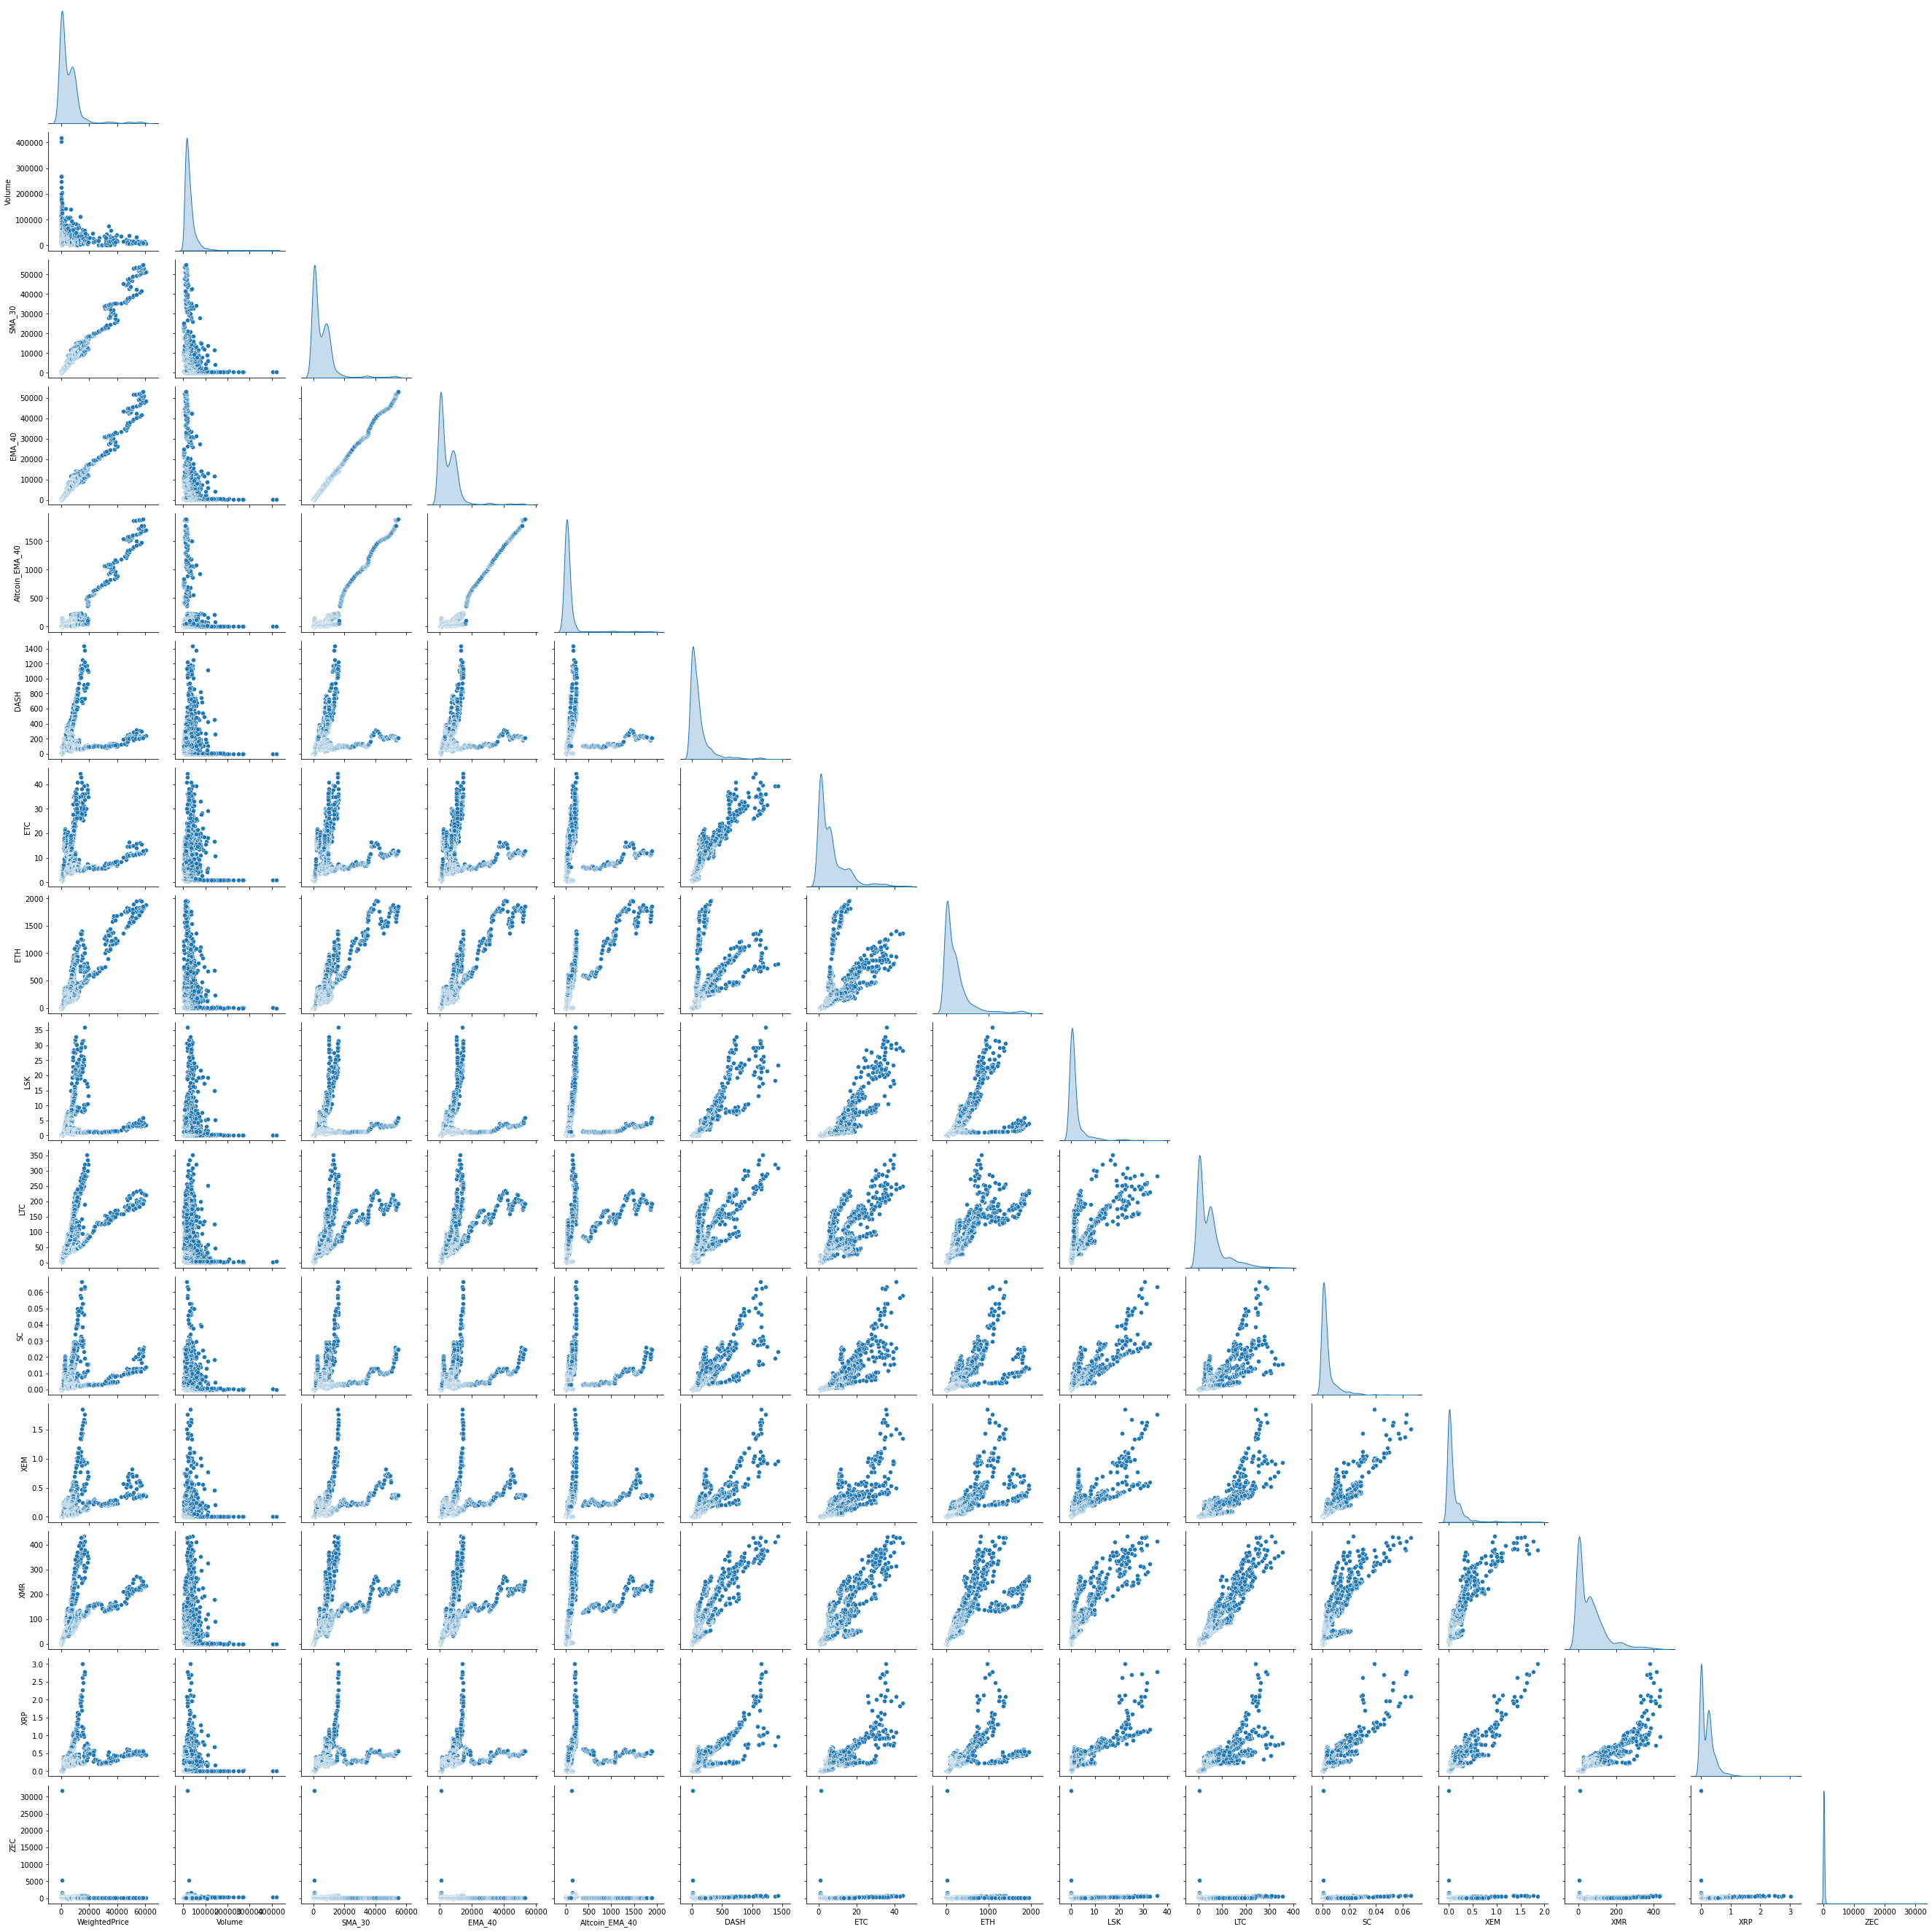

In [164]:
sns.pairplot(btc_altcoin_dataset_cleansed, diag_kind='kde', corner=True)

### Hypothesis Testing

In [165]:
btc_altcoin_OLS = btc_altcoin_prepared[['WeightedPrice', 'Altcoin_EMA_40']].reset_index().drop('Date', axis=1)

In [166]:
btc_altcoin_OLS

WeightedPrice  Altcoin_EMA_40
0        875.455969       22.772790
1        936.596268       22.789424
2        859.785532       22.661675
3        821.643821       22.480622
4        819.404772       22.277016
...             ...             ...
2645   58565.891748     1846.969313
2646   57566.981078     1854.749106
2647   58318.050615     1862.796041
2648   58337.487728     1871.520143
2649   56729.622038     1871.856677

[2650 rows x 2 columns]

In [167]:
btc_altcoin_OLS.describe()

WeightedPrice  Altcoin_EMA_40
count    2650.000000     2650.000000
mean     6005.138970       89.274790
std      9267.316088      268.981202
min       197.871603        0.822371
25%       471.125039        2.809472
50%      3426.169650       21.369616
75%      8466.844669       49.783202
max     60354.631384     1887.398710

In [168]:
btc_altcoin_OLS_pc = btc_altcoin_OLS.pct_change()

In [169]:
np.isfinite(btc_altcoin_OLS_pc)

WeightedPrice  Altcoin_EMA_40
0             False           False
1              True            True
2              True            True
3              True            True
4              True            True
...             ...             ...
2645           True            True
2646           True            True
2647           True            True
2648           True            True
2649           True            True

[2650 rows x 2 columns]

In [170]:
btc_altcoin_OLS_pc.isna().sum()

WeightedPrice     1
Altcoin_EMA_40    1
dtype: int64

In [171]:
btc_altcoin_OLS_pc.dropna(inplace=True)

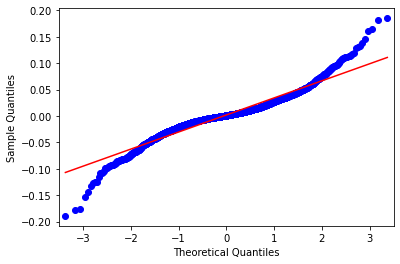

In [172]:
qqplot(btc_altcoin_OLS_pc['WeightedPrice'], line='s')
plt.show()

In [173]:
X_train, X_test, y_train, y_test = train_test_split(btc_altcoin_OLS_pc['Altcoin_EMA_40'],
                                                    btc_altcoin_OLS_pc['WeightedPrice'],
                                                    test_size=0.2, random_state=12)

In [174]:
X = btc_altcoin_OLS['Altcoin_EMA_40']
X = sm.add_constant(X)
Y = btc_altcoin_OLS['WeightedPrice']

In [175]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

In [176]:
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:          WeightedPrice   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.842
Method:                 Least Squares   F-statistic:                 1.412e+04
Date:                Sat, 10 Apr 2021   Prob (F-statistic):               0.00
Time:                        01:39:30   Log-Likelihood:                -25520.
No. Observations:                2650   AIC:                         5.104e+04
Df Residuals:                    2648   BIC:                         5.106e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           3182.6208     75.394     42.

#### Interpretation

<ul>
    <li>Adj R-square: good model fit</li>
    <li>Constant: Independent Average price of BTC over 7 Years</li>
    <li>Std error: high level of accuracy</li>
    <li>p-value: Model is statistically significant</li>
    <li>Durbin-Watson test: a positive autocorrelation is present, eg a EMA of the Altcoins yesterday is indicating a greater likelihood in BTC price increase in the future</li>
    
    
</ul>